# **Description:**


---


---


**Filename**: EEA_Hurricanes_15(Final)_[GEV_Models] \\
**Version**: 15 (Final)

---


**Key Points/Updates**: 

*   Implementing joint constraint reparameterization with upper bound and lower bound on $\xi$
* Estimating  $\mu, \sigma, \xi $ (assuming local $\mu, \sigma, \xi $)
* Estimating $ \hat{y}, y_{q1}, y_{q2}$
* Baselines: FCN, LSTM
* Loss = $\lambda_1*\text{GEV_Loss}(y, \mu, \sigma, \xi_p, \xi_n) + (1-\lambda_1)*RMSE(y, \hat{y}) $ 
  * GEV_Loss = $\lambda_2*NLL(y, \mu, \sigma, \xi_p) + (1-\lambda_2)*RMSE(\xi_p, \xi_n) $ 
  * $ \hat{y} =$ output from model
* GEV parameters estimation analysis





 



---



---






In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
from pandas import DataFrame
import pandas as pd
import numpy as np
import os, random
import math 
import scipy.io
import matplotlib.pyplot as plt
from matplotlib import rc, style
import seaborn as sns
import datetime as dt
from tqdm import tqdm as tq
from numpy import vstack, sqrt
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from pandas.plotting import register_matplotlib_converters
import matplotlib.patches as mpatches
from google.colab import files
from statistics import mean
import scipy.stats as stats
from scipy.special import gamma

from scipy.stats import genextreme
from scipy.stats import pearsonr

from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib.patches as mpatches

from functools import partial
from pylab import rcParams

import torch
from torch import nn, optim
import torchvision
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
from torch.nn import init
from torch.utils.data import random_split
import torchvision.transforms as transforms
from torchvision import models
from torchsummary import summary

# from ray import tune
# from ray.tune import CLIReporter
# from ray.tune.schedulers import ASHAScheduler
# from ray.tune.stopper import TrialPlateauStopper

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.8)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#93D30C", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 24, 10
register_matplotlib_converters()

RANDOM_SEED = 0
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
CUDA_LAUNCH_BLOCKING=1
torch.use_deterministic_algorithms(False)

**Data Loading**

In [4]:
data_path = '/content/drive/MyDrive/PhD-Research-Phase-1/Ausgrid/'

In [55]:
df = pd.read_csv(data_path+'Energy_Dataset.csv')
df.head()

,Customer,Postcode,Timestamp,Solar_Production_kWh,Energy_Consumption_kWh,Heating_Consumption_kWh,Price_AUD/MWh,Total_Demand_MWh,Latitude,Longitude
0,2,2259,2012-07-01 00:30:00,0.0,0.167,0.0,57.04,8097.93,-33.222529,151.277495
1,2,2259,2012-07-01 01:00:00,0.0,0.108,0.0,53.69,7852.57,-33.222529,151.277495
2,2,2259,2012-07-01 01:30:00,0.0,0.119,0.0,51.94,7632.28,-33.222529,151.277495
3,2,2259,2012-07-01 02:00:00,0.0,0.150,0.0,52.13,7384.70,-33.222529,151.277495
4,2,2259,2012-07-01 02:30:00,0.0,0.109,0.0,47.44,7112.43,-33.222529,151.277495


In [56]:
filtered_customer_id = [2, 13, 14, 20, 33, 35, 38, 39, 56,
                        69, 73, 74, 75, 82, 87, 88, 101, 104,
                        106, 109, 110, 119, 124, 130, 137, 141, 144,
                        152, 153, 157, 161, 169, 176, 184, 188, 189,
                        193, 201, 202, 204, 206, 207, 210, 211, 212,
                        214, 218, 244, 246, 253, 256, 273, 276, 297 
                       ]
df = df[df.Customer.isin(filtered_customer_id)]
df = df[['Customer','Energy_Consumption_kWh']]

In [57]:
df.describe()

,Customer,Energy_Consumption_kWh
count,942192.000000,942192.000000
mean,144.567375,0.357905
std,76.267573,0.432179
min,2.000000,0.000000
25%,82.000000,0.115000
50%,152.000000,0.213000
75%,206.000000,0.420000
max,297.000000,5.871000


In [58]:
data = df["Energy_Consumption_kWh"].to_numpy()
data.shape, data[0:5]

((942192,), array([0.167, 0.108, 0.119, 0.15 , 0.109]))

In [59]:
df[df.Customer.isin([2])]['Energy_Consumption_kWh'].to_numpy().shape

(13632,)

In [36]:
filtered_customer_id = [2, 13, 14, 20, 33, 35, 38, 39, 56,
                        69, 73, 74, 75, 82, 87, 88, 101, 104,
                        106, 109, 110, 119, 124, 130, 137, 141, 144,
                        152, 153, 157, 161, 169, 176, 184, 188, 189,
                        193, 201, 202, 204, 206, 207, 210, 211, 212,
                        214, 218, 244, 246, 253, 256, 273, 276, 297 
                       ]
d = [] 
d.append(df[df.Customer.isin([2])]['Energy_Consumption_kWh'].to_numpy())
d.append(df[df.Customer.isin([33])]['Energy_Consumption_kWh'].to_numpy())
d.append(df[df.Customer.isin([109])]['Energy_Consumption_kWh'].to_numpy())
d.append(df[df.Customer.isin([211])]['Energy_Consumption_kWh'].to_numpy())
d.append(df[df.Customer.isin([273])]['Energy_Consumption_kWh'].to_numpy())
dat = np.array(d)
dat.shape

(5,)

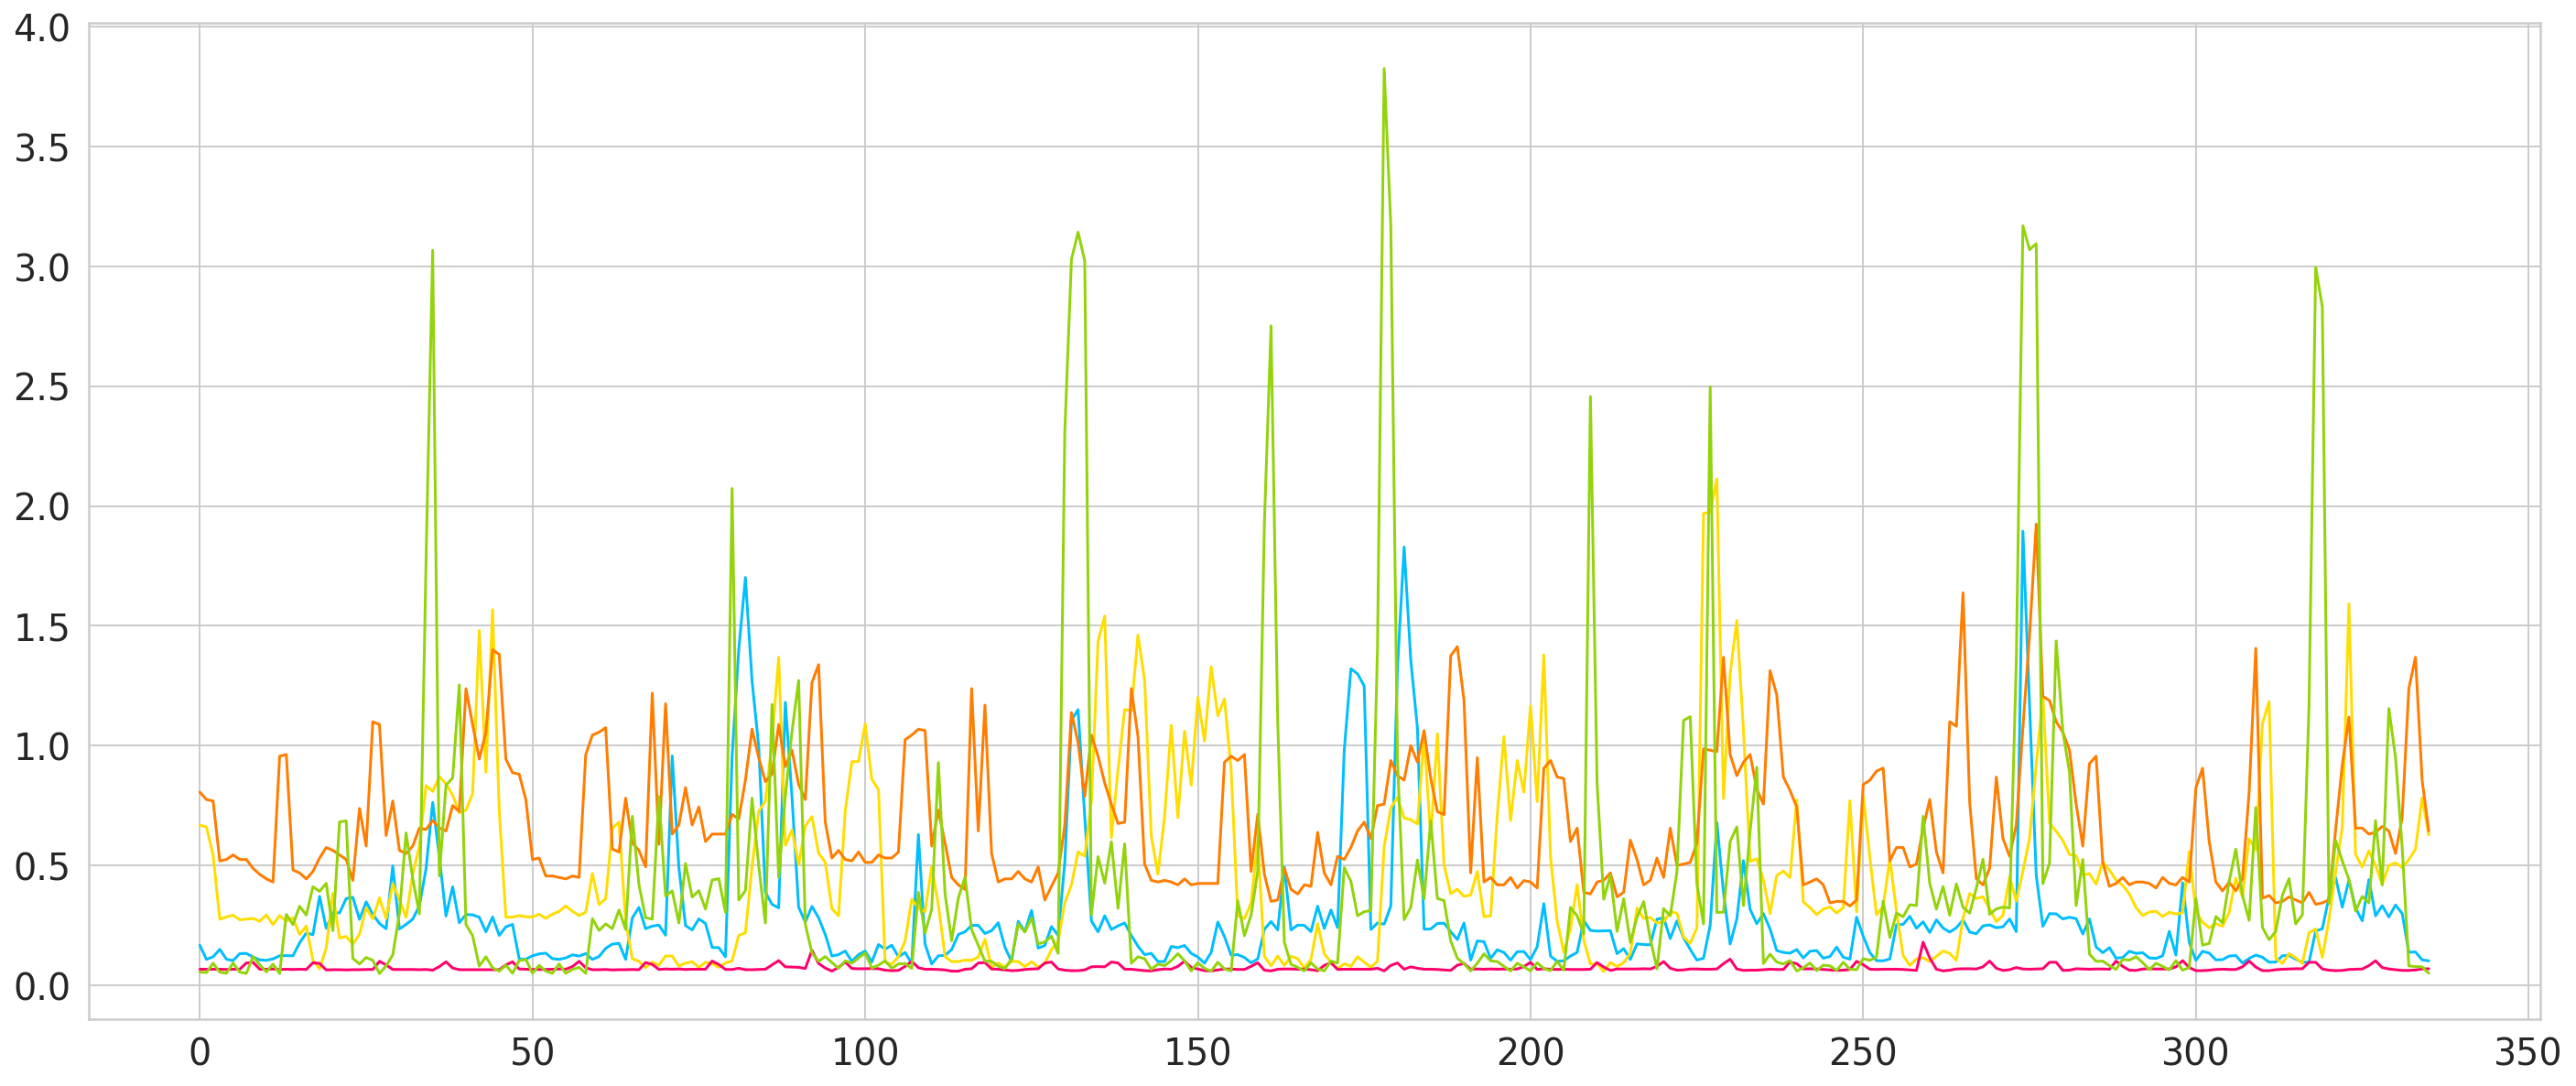

In [44]:
for i in range(5):
  x = np.arange(48*7)
  plt.plot(x, dat[i][0:48*7])

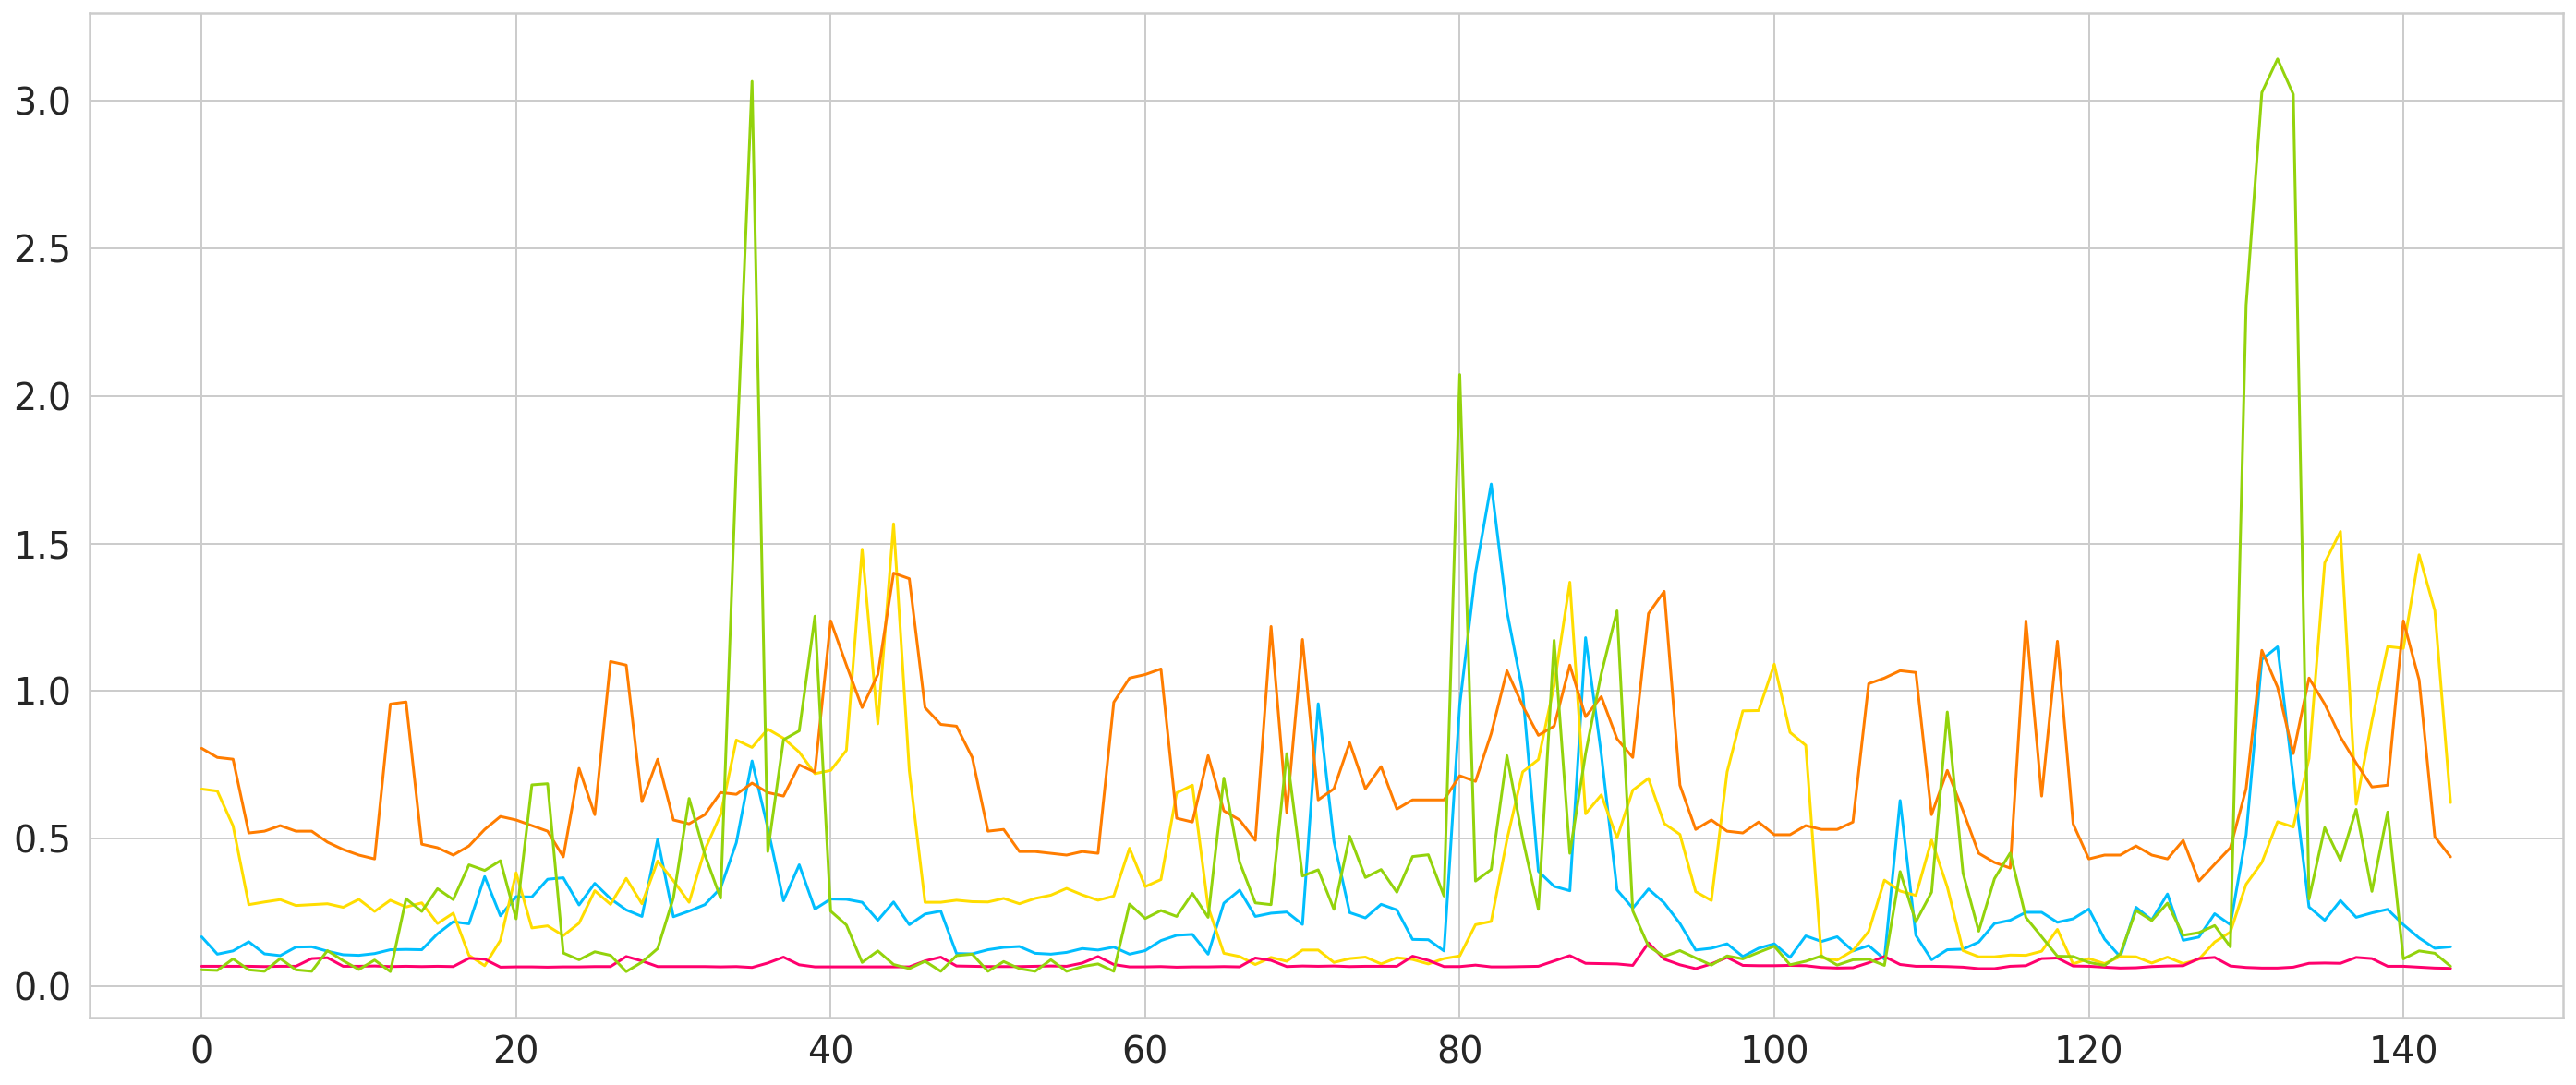

In [46]:
for i in range(5):
  x = np.arange(48*3)
  plt.plot(x, dat[i][0:48*3])

**General Hyperparameters**

In [47]:
train_test_ratio = 0.9 
batch_size = 128

**General Functions**

In [48]:
def calculate_nll(block_maxima, mu, sigma, xi, name="Test", is_return = False):
  size =  block_maxima.shape[0]
  block_maxima = torch.flatten(block_maxima.cpu())
  if not torch.is_tensor(mu): 
      mu = torch.from_numpy(mu).float().to(device)
  if not torch.is_tensor(sigma): 
      sigma = torch.from_numpy(sigma).float().to(device)
  if not torch.is_tensor(xi): 
      xi = torch.from_numpy(xi).float().to(device)
  if mu.numel() == 1: 
      mu = torch.flatten(torch.full((size,1), mu))
  if sigma.numel() == 1: 
      sigma = torch.flatten(torch.full((size,1), sigma))
  if xi.numel() == 1: 
      xi = torch.full((size,1), xi)
  mu = torch.flatten(mu).cpu()
  sigma = torch.flatten(sigma).cpu()
  xi = torch.flatten(xi).cpu()

  #using library
  log_pdf = genextreme.logpdf(block_maxima, loc = mu.detach().numpy(), scale = sigma.detach().numpy(), c = -xi.detach().numpy())
  log_likelihood = np.sum(log_pdf)
  #using vector
  # print(xi.shape, block_maxima.shape, mu.shape, sigma.shape) 
  constraint = 1+(xi/sigma)*(block_maxima-mu)
  # constraint = constraint[constraint>0]   
  constraint[constraint<0.05] = torch.tensor(0.5)
  first_term = torch.sum(torch.log(sigma))
  second_term =  (torch.sum((1+1/xi)*torch.log(constraint)))
  third_term =  torch.sum(constraint**(-1/xi))
  nll = (first_term + second_term + third_term)
  if is_return:
      return nll
  else:
      print("\n"+name+": \n")
      print("negative log likelihood using library:", -log_likelihood, " and using vector:", nll.item())
      print(f"first_term: {first_term}, second_term: {second_term}, third_term: {third_term}")

def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    numpy.random.seed(worker_seed)
    random.seed(worker_seed)

def plot_histogram(data, plot_name="Test"):
  data = np.array(data.cpu())
  plt.figure(figsize=(10,5))
  plt.hist(data, bins = 55)
  title = "Histogram of " +plot_name
  plt.title(title) 
  plt.show()

def inverse_scaler(predictions, actuals):
    predictions_inverse_scaler = scaler.inverse_transform(predictions)
    actuals_inverse_scaler = scaler.inverse_transform(actuals)
    return predictions_inverse_scaler, actuals_inverse_scaler

**Data Creation**

In [72]:
total_timesteps= 192
train_time_steps = 144
test_time_steps = total_timesteps - train_time_steps

In [74]:
data.shape[0]

942192

In [75]:
daily_data = []  
for i in range(0, data.shape[0], total_timesteps):
    daily_data.append(data[i:i+total_timesteps]) 
print(np.array(daily_data).shape)

(4908,)


In [77]:
daily_data[0][191]

0.105

In [83]:
length = int(len(daily_data)*train_test_ratio)
# random.shuffle(daily_data)
print(len(daily_data), length)
train_data = daily_data[0:length]
test_data= daily_data[length:-1]
train_data = np.array(train_data)
test_data = np.array(test_data)
print("Train and Test Data shapormalizing/standardizing:", train_data.shape, test_data.shape)

4908 4417
Train and Test Data shapormalizing/standardizing: (4417, 192) (490, 192)


**Train, Validate, Test Splits**

In [84]:
# scaler=MinMaxcaler(feature_range=(0,1))
# train_data=scaler.fit_transform(train_data.reshape(-1,1))
# 
scaler=StandardScaler()
train_data=scaler.fit_transform(train_data.reshape(-1,1))

train_data = train_data.reshape(-1,total_timesteps)
print("Train Data shape after normalizing/standardizing:", train_data.shape)

test_data=scaler.transform(test_data.reshape(-1,1))

test_data = test_data.reshape(-1,total_timesteps)
print("Train and Test Data shape before normalizing/standardizing:", train_data.shape, test_data.shape)

print("Before Validation Data: train vs test", train_data.shape, test_data.shape)

length = int(len(train_data)*train_test_ratio)
random.shuffle(train_data)
val_data= train_data[length:]
train_data = train_data[0:length]
print("After Validation Data (from train data): train vs validation vs test", train_data.shape, val_data.shape, test_data.shape)

Train Data shape after normalizing/standardizing: (4417, 192)
Train and Test Data shape before normalizing/standardizing: (4417, 192) (490, 192)
Before Validation Data: train vs test (4417, 192) (490, 192)
After Validation Data (from train data): train vs validation vs test (3975, 192) (442, 192) (490, 192)


**Data Preprocessing**

In [85]:
def extend_last_batch(X, y, batch_size=batch_size):
    last_batch_size = X.shape[0] % batch_size
    if last_batch_size != 0:
        indices = [i for i in range(0, (y.shape[0]-last_batch_size))]

        index = random.sample(indices, batch_size - last_batch_size)
        X_extended = X[index]
        y_extended = y[index]
        X = torch.cat((X, X_extended), 0)
        y = torch.cat((y, y_extended), 0)
    return X, y
def create_X_data(dataset, time_step=1):
    dataX = []
    for i in range(len(dataset)):
        X_data = dataset[i][0:time_step]
        dataX.append(X_data)
    return np.array(dataX)

def ready_X_data(train_data, val_data, test_data, train_time_steps):
      X_train = create_X_data(train_data, train_time_steps)
      X_val = create_X_data(val_data, train_time_steps)
      X_test = create_X_data(test_data, train_time_steps) 
      # reshape input to be [samples, time steps, features] which is required for LSTM
      X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
      X_val =X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)
      X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
      
      X_train = torch.from_numpy(X_train).float().to(device)
      X_val = torch.from_numpy(X_val).float().to(device)
      X_test = torch.from_numpy(X_test).float().to(device)
     
      return X_train, X_val , X_test
def create_y_data(dataset, time_step=1):
    dataY = []
    for i in range(len(dataset)):
        y_data = np.max(dataset[i][time_step:])
        dataY.append(y_data)
    return np.array(dataY)

def ready_y_data(train_data, val_data, test_data, train_time_steps):
      y_train = create_y_data(train_data, train_time_steps)
      y_val = create_y_data(val_data, train_time_steps)
      y_test = create_y_data(test_data, train_time_steps )
      y_train =y_train.reshape(-1 , 1)
      y_val =y_val.reshape(-1 , 1)
      y_test = y_test.reshape(-1, 1)

      y_train = torch.from_numpy(y_train).float().to(device)
      y_val = torch.from_numpy(y_val).float().to(device)
      y_test = torch.from_numpy(y_test).float().to(device)

      return y_train , y_val, y_test 

In [86]:
X_train, X_val, X_test = ready_X_data(train_data, val_data, test_data, train_time_steps)

y_train_max , y_val_max, y_test_max  = ready_y_data(train_data, val_data, test_data, train_time_steps)

X_train_max, y_train_max = extend_last_batch(X_train, y_train_max)
X_val_max, y_val_max = extend_last_batch(X_val, y_val_max)
X_test_max, y_test_max = extend_last_batch(X_test, y_test_max)

X_train_full_max = torch.cat((X_train_max, X_val_max), 0).to(device)
y_train_full_max = torch.cat((y_train_max, y_val_max), 0).to(device)

X_train_max.shape, y_train_max.shape, X_val_max.shape, y_val_max.shape, X_test_max.shape, y_test_max.shape

(torch.Size([4096, 144, 1]),
 torch.Size([4096, 1]),
 torch.Size([512, 144, 1]),
 torch.Size([512, 1]),
 torch.Size([512, 144, 1]),
 torch.Size([512, 1]))

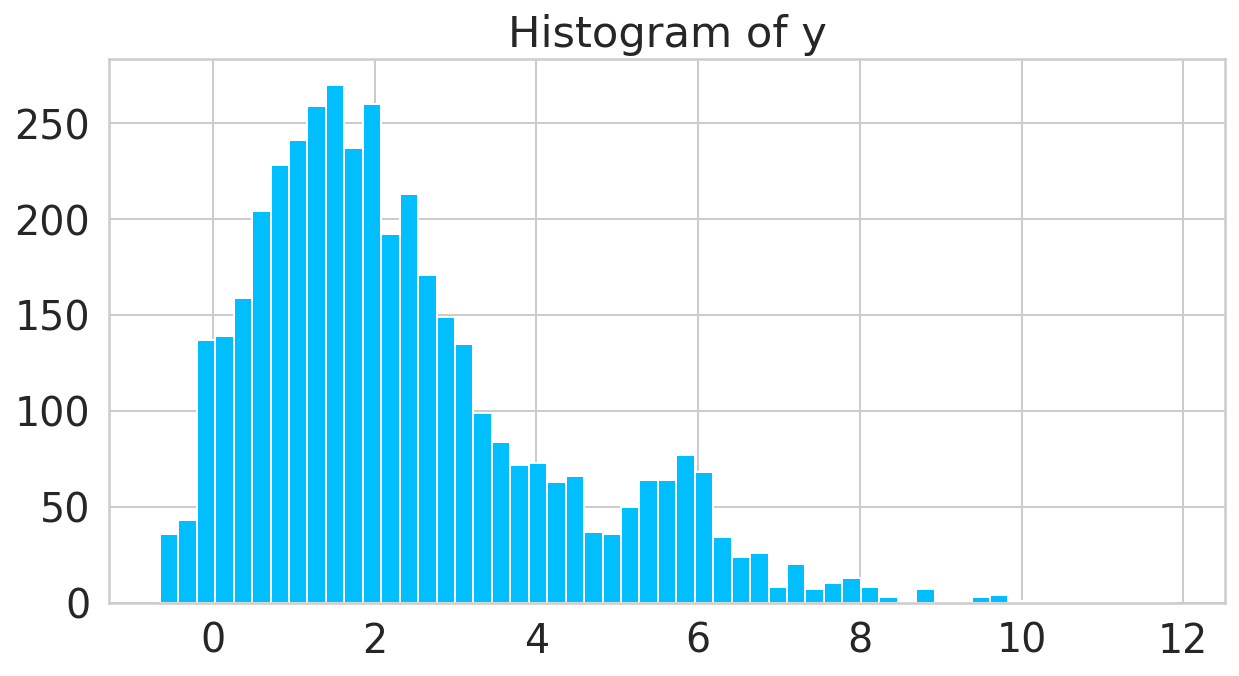

In [87]:
plot_histogram(y_train_max, plot_name = "y")

**Learning/Checking global mu, sigma, xi using y**

In [89]:
shape, loc, scale = genextreme.fit(y_train_max.cpu())
print(f"Scipy Estimated GEV Parameters: mu: {loc}, sigma: {scale}, xi: {- shape}")
calculate_nll(y_train_max.cpu(), torch.tensor(loc), torch.tensor(scale), torch.tensor(-shape), name= "Scipy estimated parameters")

Scipy Estimated GEV Parameters: mu: 1.4537066331083053, sigma: 1.3329782050244194, xi: 0.09318098209007789

Scipy estimated parameters: 

negative log likelihood using library: 7872.559183060784  and using vector: 7872.55908203125
first_term: 1177.2547607421875, second_term: 2598.791015625, third_term: 4096.51318359375


Ground Truth: mu: 0.10042655850781065, sigma: 0.7062185733985489, xi: 0.40070703165002847
Scipy Estimated GEV Parameters: mu: 0.09122930153449316, sigma: 0.7061777602720398, xi: 0.40346273454621373


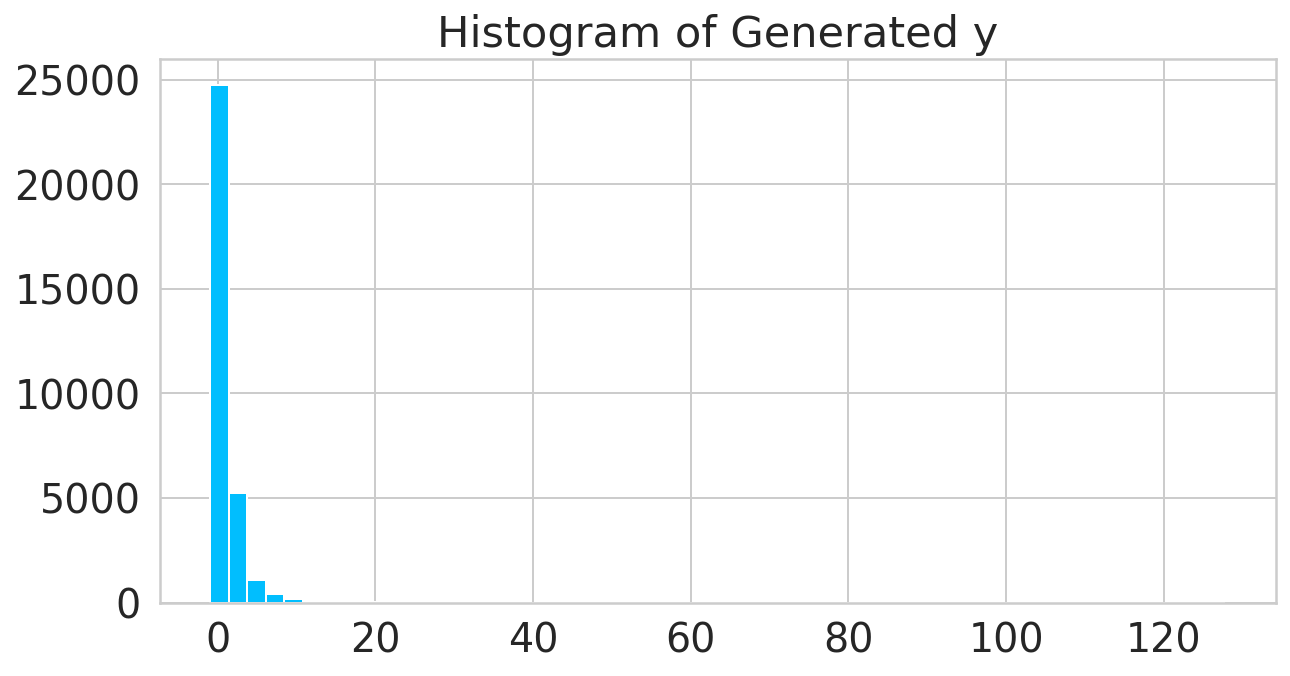

In [ ]:
#@title
def create_gev_data(mu = 0.4, sigma=0.1, xi=0.25, size=y_train_max.shape[0]): 
    data = genextreme.rvs(c=-xi, loc=mu, scale=sigma, size = size, random_state=RANDOM_SEED)
    block_maxima = data.tolist()
    shape, loc, scale = genextreme.fit(block_maxima)
    print(f"Ground Truth: mu: {mu}, sigma: {sigma}, xi: {xi}")
    print(f"Scipy Estimated GEV Parameters: mu: {loc}, sigma: {scale}, xi: {- shape}")
    # print("Lower Bound:", loc - scale/shape) 
    y_truth =torch.from_numpy(data).float().to(device)
    X_dummy = torch.ones(size)
    # print("\ny's shape and X's shape:", y_truth.shape[0], " x ", X_dummy.shape[0])
    return X_dummy, y_truth
X_dummy = torch.ones(y_train_max.shape[0])
X_dummy, y_truth = create_gev_data(mu =loc, sigma=scale, xi=-shape, size = y_train_max.shape[0])
# y_generated =scaler.inverse_transform(y_truth.reshape(-1,1))
plot_histogram(y_truth, plot_name="Generated y")

**Initialization**

In [90]:
batch_size = 128
sequence_len = train_time_steps
n_features = 1
n_hidden = 20
n_layers = 3

**Plotting and Results Functions**

In [91]:
#@title
# plotting functions
def plot_losses(train_history, validation_history, test_history, ylim_low=0,ylim_high=0.05):
    plt.plot(train_history, label="Training loss")
    plt.plot(validation_history, label="Validation loss")
    plt.plot(test_history, label="Test loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    # plt.ylim((ylim_low, ylim_high))
    plt.legend();
  

In [92]:
#@title
def plot_scatter(x, y, model_name = None, is_download = False): 
    rcParams['figure.figsize'] = 24, 10
    plt.style.use('default')
    ax = plt
    plt.scatter(x, y, color ='green', label= 'Predicted')
    plt.plot([x.min(), x.max()], [x.min(), x.max()], color='red', label = 'Actual') 
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    # plt.suptitle(model_name)
    # function to show the plot
    if is_download:
        plt.savefig(model_name+'point.jpg')
        files.download(model_name+'point.jpg')
    plt.legend(loc='best')
    plt.show()    

In [93]:
#@title
def plot_plot_y(y_t, y_p, y1 = None, y2=None, model_name = None, is_download = False): 
    rcParams['figure.figsize'] = 24, 10
    plt.style.use('default')
    x = torch.linspace(1,y_t.size()[0],y_t.size()[0])
    plt.plot(x, y_t, color ='tomato', label= 'Actual')
    plt.plot(x, y_p, color ='yellowgreen', label= 'Predictions')
    # if not (y1 is None):
    #   plt.plot(x, y1, color ='navajowhite', label = '10%Q')
    #   plt.plot(x, y2, color ='skyblue', label='90%Q')
    plt.fill_between(x, y1, y2, facecolor='lightgrey')
    envelop_patch = mpatches.Patch(color='lightgrey', label='Qunatile (90%)')
    plt.legend(handles=[envelop_patch])
    # plt.plot([0, x.max().item()], [0, x.max().item()], color='red', label = 'Actual') 
    plt.xlabel('Datapoints')
    plt.ylabel('Block Maxima')
    # plt.suptitle(model_name)
    # function to show the plot
    plt.legend(loc='best')
    if is_download:
        plt.savefig(model_name+'quantile.jpg')
        files.download(model_name+'quantile.jpg')
    
    plt.show()    

In [94]:
#@title
def plot_scatter_error(xi, error, model_name = None): 
    # rcParams['figure.figsize'] = 16, 10
    # plt.style.use('fivethirtyeight')
    plt.scatter(xi, error, color ='green')
    plt.axhline(y=0.0, color='red')
    # plt.plot([0, 0], [0, 0]) 
    plt.xlabel('Actual')
    plt.ylabel('Error')
    plt.suptitle(model_name)
    # function to show the plot
    # plt.savefig(model_name+'.jpg')
    # files.download(model_name+'.jpg')
    plt.show()    

In [95]:
def parameters_relation(y=None, z=None, parameter_name="xi", is_for_yhat=False, is_download=False):

    x = np.arange(0,y.shape[0],1)
    if is_for_yhat: y = y.numpy()
    else: y = y.numpy()
    
    # rcParams['figure.figsize'] = 16, 10
    # plt.style.use('default')
    # plt.plot(y, z, color ='red')
    # plt.xlabel('Block Maxima')
    # plt.ylabel(str(parameter_name))
    # # function to show the plot
    # # plt.savefig(parameter_name+' line .jpg')
    # # files.download(parameter_name+' line.jpg')
    # plt.show()    

    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)

    fig, ax = plt.subplots(1, 1, sharex=True, sharey=True)
    ax.set_xlim(np.min(x), np.max(x))
    ax.set_ylim(np.min(y), np.max(y))
    # Create a continuous norm to map from data points to colors
    norm = plt.Normalize(z.min(), z.max())
    lc = LineCollection(segments, cmap='viridis', norm=norm)
    # Set the values used for colormapping
    lc.set_array(z)
    lc.set_linewidth(5)
    line = ax.add_collection(lc)
    ax.set_xlabel('Data-points')
    if is_for_yhat: ax.set_ylabel('Predicted Block Maxima')
    else: ax.set_ylabel('Actual Block Maxima')
    # ax.set_title('Relation with GEV Parameters')
    axcb = fig.colorbar(line, ax=ax)
    if parameter_name is 'xi': axcb.set_label(r'$\xi$')
    elif parameter_name is 'sigma': axcb.set_label(r'$\sigma$')
    elif parameter_name is 'mu': axcb.set_label(r'$\mu$')
    if is_download:
      fig.savefig(parameter_name+'.jpg')
      files.download(parameter_name+'.jpg')
    fig.show()

In [96]:
def all_result(y_all, yhat_all, y_q1_all, y_q2_all, mu_hat_all, sigma_hat_all, xi_hat_all, model_name="Test"):
    print("PICP: ", calculate_PICP(y_all,y_q1_all, y_q2_all))
    print("Correlation between actual and Predicted (mean): ", calculate_corr(y_all, yhat_all))
    print("RMSE of y (standardized): ", ((y_all - yhat_all) ** 2).mean().sqrt().item())
    y_all, yhat_all = inverse_scaler(y_all.tolist(), yhat_all.tolist())
    y_q1_all, y_q2_all = inverse_scaler(y_q1_all.reshape(-1,1).tolist(), y_q2_all.reshape(-1,1).tolist())
    print("RMSE of y : ", math.sqrt(mean_squared_error(y_all,yhat_all)))
    plot_scatter(y_all, yhat_all, model_name="Model M3: y estimations", is_download = False)
    y_all_sorted, indices = torch.sort(torch.from_numpy(y_all.flatten()))
    yhat_all_sorted = torch.from_numpy(yhat_all.flatten())[indices]
    y_q1_all_sorted = y_q1_all[indices]
    y_q2_all_sorted = y_q2_all[indices]
    xi_hat_all_sorted = xi_hat_all[indices]
    sigma_hat_all_sorted = sigma_hat_all[indices]
    mu_hat_all_sorted = mu_hat_all[indices]
    # print(yhat_all_sorted)
    # plt.plot(y_all_sorted, yhat_all_sorted)
    plot_plot_y(y_all_sorted.reshape(-1), yhat_all_sorted.reshape(-1), y1=y_q1_all_sorted.reshape(-1), y2= y_q2_all_sorted.reshape(-1), model_name="Model M3: y estimations", is_download = False)
    # parameters_relation(y=yhat_all_sorted, z=mu_hat_all_sorted, parameter_name="mu", is_for_yhat=True)
    # parameters_relation(y=yhat_all_sorted, z=sigma_hat_all_sorted, parameter_name="sigma", is_for_yhat=True)
    # parameters_relation(y=yhat_all_sorted, z=xi_hat_all_sorted, parameter_name="xi", is_for_yhat=True)
    parameters_relation(y=y_all_sorted.flatten(), z=mu_hat_all_sorted, parameter_name="mu", is_for_yhat=False, is_download=False)
    parameters_relation(y=y_all_sorted.flatten(), z=sigma_hat_all_sorted, parameter_name="sigma", is_for_yhat=False, is_download=False)
    parameters_relation(y=y_all_sorted.flatten(), z=xi_hat_all_sorted, parameter_name="xi", is_for_yhat=False, is_download=False)
    output = np.column_stack((y_all_sorted.flatten(),yhat_all_sorted.flatten(), y_q1_all_sorted.flatten(), y_q2_all_sorted.flatten(), xi_hat_all_sorted.numpy().flatten(), sigma_hat_all_sorted.numpy().flatten(), mu_hat_all_sorted.numpy().flatten()))
    np.savetxt(model_name+'.csv',output,delimiter=',')



In [97]:
def calculate_PICP(y_all,y_q1_all, y_q2_all):
    captured_data = 0 
    total_data = y_all.shape[0]
    for i in range(total_data):
      if (y_all[i] < y_q2_all[i]) and y_all[i] > y_q1_all[i]: captured_data+=1
    PICP = captured_data/total_data
    return PICP
def calculate_corr(y_all,yhat_all):
    corr, _ = pearsonr(y_all.reshape(-1).cpu().numpy(), yhat_all.reshape(-1).cpu().numpy())
    return corr

**Model**

In [98]:
class FCN(nn.Module):
  # output: max
  # train_loss: max
  def __init__(self, sequence_len, batch_size, n_hidden=50):
    super(FCN, self).__init__()

    self.batch_size = batch_size

    self.linear1 = nn.Linear(in_features=sequence_len, out_features=n_hidden)
    self.linear2 = nn.Linear(in_features=n_hidden, out_features=n_hidden)
    self.linear3 = nn.Linear(in_features=n_hidden, out_features=n_hidden)
    self.linearFinal = nn.Linear(in_features=n_hidden, out_features=1)

  def forward(self, input_tensor, y_max, y_min, mu_fix, sigma_fix, xi_p_fix, xi_n_fix):

      out = self.linear1(input_tensor.view(self.batch_size, -1))
      out = torch.relu(out)
      out = self.linear2(out)
      out = torch.relu(out)
      out = self.linear3(out)
      out = torch.relu(out)
      y = self.linearFinal(out)

      mu = torch.tensor([0.0,0.0])
      sigma = torch.tensor([0.0,0.0])
      xi_p = torch.tensor([0.0,0.0])
      xi_n = torch.tensor([0.0,0.0])
      return mu, sigma, xi_p, xi_n, y

In [99]:
class LSTM_GEV(nn.Module):

  def __init__(self, n_features, sequence_len, batch_size = 64, n_hidden=10, n_layers=2):
    super(LSTM_GEV, self).__init__()

    self.n_hidden = n_hidden
    self.sequence_len = sequence_len
    self.n_layers = n_layers
    self.batch_size = batch_size
    self.lstm = nn.LSTM(input_size=n_features,
                        hidden_size=n_hidden,
                        num_layers=n_layers,
                        batch_first=True,
                        bidirectional=True,
                        dropout=0)
    self.fcn = nn.Linear(in_features=n_hidden*2, out_features=4)
    self.fcn2 = nn.Linear(in_features=4, out_features=10)
    self.linear_y = nn.Linear(in_features=10, out_features=1)
    self.sigmoid = nn.Sigmoid()
    self.softplus = nn.Softplus()
  
  def reset_hidden_state(self):
    self.hidden = (
        torch.zeros(self.n_layers*2, self.batch_size, self.n_hidden).to(device),
        torch.zeros(self.n_layers*2, self.batch_size, self.n_hidden).to(device)
    )

  def forward(self, input_tensor, y_max, y_min, mu_fix, sigma_fix, xi_p_fix, xi_n_fix):

      self.reset_hidden_state()
      lstm_out, self.hidden = self.lstm(input_tensor.view(self.batch_size, self.sequence_len, -1), self.hidden) # lstm_out (batch_size, seq_len, hidden_size*2)
      out = lstm_out[:, -1, :]    # getting only the last time step's hidden state of the last layer
      # print("hidden states mean, std, min, max: ", lstm_out[:,:,:].mean().item(), lstm_out[:,:,:].std().item(), lstm_out[:,:,:].min().item(), lstm_out[:,:,:].max().item()) # lstm_out.shape -> out.shape: 64,16,100 -> 64,16. Batch size: 64, input_seq_len:  16, n_hidden*2 = 50*2 = 100 // *2 for bidirectional lstm
      out = self.fcn(out)   # feeding lstm output to a fully connected network which outputs 3 nodes: mu, sigma, xi  
      out = self.fcn2(out) 
      y = self.linear_y(out)
      mu = torch.tensor([0.0,0.0])
      sigma = torch.tensor([0.0,0.0])
      xi_p = torch.tensor([0.0,0.0])
      xi_n = torch.tensor([0.0,0.0])
      return mu, sigma, xi_p, xi_n, y

In [143]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()       
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        #pe.requires_grad = False
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:x.size(0), :]
          

class TransAm(nn.Module):
    def __init__(self,feature_size=250,num_layers=1,dropout=0.1):
        super(TransAm, self).__init__()
        self.model_type = 'Transformer'
        self.feature_size = feature_size
        self.src_mask = None
        self.pos_encoder = PositionalEncoding(feature_size)
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=feature_size, nhead=10, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)        
        self.decoder1 = nn.Linear(train_time_steps*feature_size,200)
        self.decoder2 = nn.Linear(200,50)
        self.decoder3 = nn.Linear(50,10)
        self.decoder4 = nn.Linear(10,5)
        self.decoder5 = nn.Linear(5,1)
        
        self.init_weights()

    def init_weights(self):
        initrange = 0.1    
        self.decoder1.bias.data.zero_()
        self.decoder1.weight.data.uniform_(-initrange, initrange)

    def forward(self,src, y_max, y_min, mu_fix, sigma_fix, xi_p_fix, xi_n_fix):
        src = src.reshape(train_time_steps, batch_size, -1)
        # if self.src_mask is None or self.src_mask.size(0) != len(src):
        #     device = src.device
        #     mask = self._generate_square_subsequent_mask(len(src)).to(device)
        #     self.src_mask = mask
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src,self.src_mask)#, self.src_mask)
        output = output.reshape(batch_size, train_time_steps*self.feature_size )
        output = self.decoder1(output)
        output = self.decoder2(output)
        output = self.decoder3(output)
        output = self.decoder4(output)
        output = self.decoder5(output)

        mu = torch.tensor([0.0,0.0])
        sigma = torch.tensor([0.0,0.0])
        xi_p = torch.tensor([0.0,0.0])
        xi_n = torch.tensor([0.0,0.0])
        return mu, sigma, xi_p, xi_n, output

    def _generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask


In [101]:
class M2_GEV(nn.Module):

  def __init__(self, n_features, sequence_len, batch_size = 64, n_hidden=10, n_layers=2):
    super(M2_GEV, self).__init__()

    self.n_hidden = n_hidden
    self.sequence_len = sequence_len
    self.n_layers = n_layers
    self.batch_size = batch_size
    self.lstm = nn.LSTM(input_size=n_features,
                        hidden_size=n_hidden,
                        num_layers=n_layers,
                        batch_first=True,
                        bidirectional=True,
                        dropout=0)
    self.fcn = nn.Linear(in_features=n_hidden*2, out_features=4)
    # self.fcn2 = nn.Linear(in_features=10, out_features=4)
    self.fcn_mu = nn.Linear(in_features=4, out_features=1)
    self.fcn_sigma = nn.Linear(in_features=4, out_features=1)
    self.fcn_xi_p = nn.Linear(in_features=4, out_features=1)
    self.fcn_xi_n = nn.Linear(in_features=4, out_features=1)
    self.sigmoid = nn.Sigmoid()
    self.softplus = nn.Softplus()
  
  def reset_hidden_state(self):
    self.hidden = (
        torch.zeros(self.n_layers*2, self.batch_size, self.n_hidden).to(device),
        torch.zeros(self.n_layers*2, self.batch_size, self.n_hidden).to(device)
    )

  def forward(self, input_tensor, y_max, y_min, mu_fix, sigma_fix, xi_p_fix, xi_n_fix):

      self.reset_hidden_state()
      self.mu_fix = mu_fix
      self.sigma_fix = sigma_fix
      self.xi_p_fix = xi_p_fix
      self.xi_n_fix = xi_n_fix

      lstm_out, self.hidden = self.lstm(input_tensor.view(self.batch_size, self.sequence_len, -1), self.hidden) # lstm_out (batch_size, seq_len, hidden_size*2)
      out = lstm_out[:, -1, :]    # getting only the last time step's hidden state of the last layer
      # print("hidden states mean, std, min, max: ", lstm_out[:,:,:].mean().item(), lstm_out[:,:,:].std().item(), lstm_out[:,:,:].min().item(), lstm_out[:,:,:].max().item()) # lstm_out.shape -> out.shape: 64,16,100 -> 64,16. Batch size: 64, input_seq_len:  16, n_hidden*2 = 50*2 = 100 // *2 for bidirectional lstm
      out = self.fcn(out)   # feeding lstm output to a fully connected network which outputs 3 nodes: mu, sigma, xi  
      # out = self.fcn2(out) 
      # out = self.softplus(out)
      mu = (self.fcn_mu(out))  - self.mu_fix
      p1 = (self.fcn_sigma(out))
      p2 = (self.fcn_xi_p(out))
      p3 = (self.fcn_xi_n(out))
      p2 = self.softplus(p2)
      p3 = self.softplus(p2)

      # p2[p2<=0] = torch.tensor(0.05)
      # p3[p3<=0] = torch.tensor(0.05)
      sigma = self.softplus(p1)  - self.sigma_fix  
      xi_p =  ((sigma/(mu-y_min))*(1+boundary_tolerance) - (p2))  - self.xi_p_fix
      xi_n = ((p3) - (sigma/(y_max-mu))*(1+boundary_tolerance))  - self.xi_n_fix
      xi_p[xi_p>0.95] = torch.tensor(0.95)
      gamma_part = gamma((1-xi_p).detach().numpy())
      y_mean = mu + (sigma/xi_p)*(torch.tensor(gamma_part) -1)
      # y_mean = mu + (sigma/xi_p)*(((math.log(2.0))**(-xi_p)) - 1)
      return mu, sigma, xi_p, xi_n, y_mean

In [102]:
class M3_GEV(nn.Module):

  def __init__(self, n_features, sequence_len, batch_size = 64, n_hidden=10, n_layers=2):
    super(M3_GEV, self).__init__()

    self.n_hidden = n_hidden
    self.sequence_len = sequence_len
    self.n_layers = n_layers
    self.batch_size = batch_size
    self.lstm = nn.LSTM(input_size=n_features,
                        hidden_size=n_hidden,
                        num_layers=n_layers,
                        batch_first=True,
                        bidirectional=True,
                        dropout=0)
    self.fcn = nn.Linear(in_features=n_hidden*2, out_features=4)
    self.fcn2 = nn.Linear(in_features=4, out_features=10)
    self.linear_y = nn.Linear(in_features=10, out_features=1)
     
    self.sigmoid = nn.Sigmoid()
    self.softplus = nn.Softplus()
  
  def reset_hidden_state(self):
    self.hidden = (
        torch.zeros(self.n_layers*2, self.batch_size, self.n_hidden).to(device),
        torch.zeros(self.n_layers*2, self.batch_size, self.n_hidden).to(device)
    )

  def forward(self, input_tensor, y_max, y_min, mu_fix, sigma_fix, xi_p_fix, xi_n_fix):

      self.reset_hidden_state()
      self.mu_fix = mu_fix
      self.sigma_fix = sigma_fix
      self.xi_p_fix = xi_p_fix
      self.xi_n_fix = xi_n_fix

      lstm_out, self.hidden = self.lstm(input_tensor.view(self.batch_size, self.sequence_len, -1), self.hidden) # lstm_out (batch_size, seq_len, hidden_size*2)
      out = lstm_out[:, -1, :]    # getting only the last time step's hidden state of the last layer
      out = self.fcn(out)   # feeding lstm output to a fully connected network which outputs 3 nodes: mu, sigma, xi  
      
      mu = out[:, 0]  - self.mu_fix      # mu: first node of the fully connected network
      p1 = out[:, 1]     # sigma: second node of the fully connected network
      p2 = out[:, 2]   
      p3 = out[:, 3] 
      p2 = self.softplus(p2)
      p3 = self.softplus(p2)
      sigma = self.softplus(p1)  - self.sigma_fix  
      xi_p =  ((sigma/(mu-y_min))*(1+boundary_tolerance) - (p2))  - self.xi_p_fix
      xi_n = ((p3) - (sigma/(y_max-mu))*(1+boundary_tolerance))  - self.xi_n_fix
      xi_p[xi_p>0.95] = torch.tensor(0.95)

      out = self.fcn2(out)
      yhat = self.linear_y(out)
      
      return mu, sigma, xi_p, xi_n, yhat

**Training**

In [103]:
torch.use_deterministic_algorithms(False)

In [140]:
def train_model_gev(model_name=None, lambda_ =None, lambda_2 =None, config=None, checkpoint_dir=None,tuning = False, validation = True, final_train = False, X_train = X_train_max, y_train = y_train_max):
    if tuning: 
        if model_name=="LSTM_max": 
            model = LSTM_max(n_features, sequence_len, batch_size, config["n_hidden"], config["n_layers"])
        # todo: tune for other models
        optimizer = torch.optim.Adam(model.parameters(), lr=config["lr"])
    else: 
        if model_name == "M1_GEV":
            model = M1_GEV(input_size, batch_size, n_hidden)
        elif model_name == "FCN":
            model = FCN(sequence_len, batch_size, n_hidden)
        elif model_name == "M2_GEV":
            model = M2_GEV(n_features, sequence_len, batch_size, n_hidden, n_layers)
        elif model_name == "LSTM_GEV":
            model = LSTM_GEV(n_features, sequence_len, batch_size, n_hidden, n_layers)
        elif model_name == "M3_GEV":
            model = M3_GEV(n_features, sequence_len, batch_size, n_hidden, n_layers)
        elif model_name == "Trans":
            model = TransAm(feature_size=40,num_layers=4,dropout=0.0)
            # model.apply(init_weights)
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)


    device = "cpu"
    
    if torch.cuda.is_available():
        device = "cuda:0"
        if torch.cuda.device_count() > 1:
            model = nn.DataParallel(model)
    model.to(device)

    if checkpoint_dir:
        model_state, optimizer_state = torch.load(
            os.path.join(checkpoint_dir, "checkpoint"))
        model.load_state_dict(model_state)
        optimizer.load_state_dict(optimizer_state)
        
    train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, worker_init_fn=seed_worker) 
    if validation:
        validation_loader = DataLoader(TensorDataset(X_val_max, y_val_max), batch_size=batch_size,worker_init_fn=seed_worker) 
        test_loader = DataLoader(TensorDataset(X_test_max, y_test_max), batch_size=batch_size, worker_init_fn=seed_worker)

    small_value = torch.tensor(0.05)
    zero_tensor = torch.tensor(0.0)
    q1 = torch.tensor(0.05)
    q2 = torch.tensor(0.95)
    y_max = y_train.max()
    y_min = y_train.min()

    mu_hat_all = torch.empty(0).to(device)
    sigma_hat_all = torch.empty(0).to(device)
    xi_hat_all = torch.empty(0).to(device)
    y_all = torch.empty(0).to(device)
    y_hat_all = torch.empty(0).to(device)
    y_q1_all = torch.empty(0).to(device) 
    y_q2_all = torch.empty(0).to(device) 

    xi_scipy, mu_init, sigma_init = torch.tensor(genextreme.fit(y_train.cpu()))
    xi_p_init = -xi_scipy  + 0.05 #torch.tensor(-0.05)#
    xi_n_init = -xi_scipy - 0.05 #torch.tensor(-0.10)
    print(f'y_max, y_min: {y_max, y_min}')

    for epoch in (range(num_epochs)):
      with torch.autograd.set_detect_anomaly(True) : 
        for i, (inputs, labels) in enumerate(train_loader): 
            if epoch == 0 and i == 0 and lambda_>0.0: 
                with torch.no_grad():    
                    mu_temp, sigma_temp, xi_p_temp, xi_n_temp, yhat_temp = model(inputs, y_max, y_min, zero_tensor, zero_tensor, zero_tensor, zero_tensor) 
                    mu_fix = mu_temp - mu_init
                    sigma_fix = sigma_temp - sigma_init
                    mu_temp, sigma_temp, xi_p_temp, xi_n_temp, yhat_temp = model(inputs, y_max, y_min, mu_fix, sigma_fix, zero_tensor, zero_tensor) 
                    xi_p_fix = xi_p_temp - xi_p_init
                    xi_n_fix = xi_n_temp - xi_n_init
                    print(f'initial values: mu (mean): {mu_temp.mean().item()}, sigma (mean): {sigma_temp.mean().item()}, xi_p (mean): {xi_p_temp.mean().item()}, xi_n (mean): {xi_n_temp.mean().item()}')
            if lambda_>0.0:
                mu, sigma, xi_p, xi_n, yhat = model(inputs, y_max, y_min, mu_fix, sigma_fix, xi_p_fix, xi_n_fix) 
                # y_med = mu + (sigma/xi_p)*(((math.log(2.0))**(-xi_p)) - 1)
                # y_q1 = mu + (sigma/xi_p)*(((-math.log(q1))**(-xi_p)) - 1)
                # y_q2 = mu + (sigma/xi_p)*(((-math.log(q2))**(-xi_p)) - 1)
                if epoch == 0 and i == 0: 
                    print(f'initial values after fixing:  mu (mean): {mu.mean().item()}, sigma (mean): {sigma.mean().item()}, xi_p (mean): {xi_p.mean().item()}, xi_n (mean): {xi_n.mean().item()}')
                    # break
            else: mu, sigma, xi_p, xi_n, yhat = model(inputs, y_max, y_min, zero_tensor, zero_tensor, zero_tensor, zero_tensor)           
    
            if lambda_>0.0:
                constraint = 1+(xi_p/sigma)*(labels-mu)
                count_constraint_violation.append(constraint[constraint<small_value].shape[0])  
                gev_loss = calculate_nll(labels.cpu(), mu.cpu(), sigma.cpu(), xi_p.cpu(), is_return=True)/(labels.shape[0])
                xi_rmse_loss = ((xi_p - xi_n) ** 2).mean().sqrt()
                evt_loss = lambda_2*gev_loss + (1-lambda_2)*xi_rmse_loss
            rmse_loss = ((labels - yhat) ** 2).mean().sqrt()
            # print(labels.shape, yhat.shape)
            if lambda_==0.0: train_loss = rmse_loss
            else: train_loss = lambda_*evt_loss + (1-lambda_)*rmse_loss
            # print(f'Epoch {epoch}  | Loss: | Training: {round(train_loss.item(),4)} | EVT(NLL+RMSE(xi)): {round(evt_loss.item(),4)} | RMSE(y): {round(rmse_loss.item(),4)} | GEV(NLL): {round(gev_loss.item(),4)} | RMSE(xi_p_n): {round(xi_rmse_loss.item(),4)}| mu  sigma  xi_p xi_n: {round(mu.mean().item(), 4), round(sigma.mean().item(),4), round(xi_p.mean().item(),4),round(xi_n.mean().item(),4)}')
            if torch.isinf(train_loss.mean()) or torch.isnan(train_loss.mean()):
                  print("xi_p \n",  xi_p, "ytruth \n",   labels, "yhat \n",  yhat)
                  # break
            optimizer.zero_grad() 
            train_loss.backward()
            optimizer.step()

        train_history[epoch] = train_loss.item()
        if lambda_>0.0: print(f'Epoch {epoch}  | Loss: | Training: {round(train_loss.item(),4)} | EVT(NLL+RMSE(xi)): {round(evt_loss.item(),4)} | RMSE(y): {round(rmse_loss.item(),4)} | GEV(NLL): {round(gev_loss.item(),4)} | RMSE(xi_p_n): {round(xi_rmse_loss.item(),4)}| mu  sigma  xi_p xi_n: {round(mu.mean().item(), 4), round(sigma.mean().item(),4), round(xi_p.mean().item(),4),round(xi_n.mean().item(),4)}')
        else: print(f'Epoch {epoch}  | Loss: | Training: {round(train_loss.item(),4)}') 
        if validation:
            for j, (inputs, labels) in enumerate(validation_loader):
                with torch.no_grad():       
                    if lambda_>0.0: mu, sigma, xi_p, xi_n, y_validation_predict = model(inputs, y_max, y_min, mu_fix, sigma_fix, xi_p_fix, xi_n_fix) 
                    else: mu, sigma, xi_p, xi_n, y_validation_predict = model(inputs, y_max, y_min, zero_tensor, zero_tensor, zero_tensor, zero_tensor) 
                    rmse_loss = ((y_validation_predict - labels) ** 2).mean().sqrt()
                    validation_loss = rmse_loss
            validation_history[epoch] = validation_loss.item()

            for k, (inputs, labels) in enumerate(test_loader):
                with torch.no_grad():       
                    if lambda_>0.0: mu, sigma, xi_p, xi_n, y_test_predict = model(inputs, y_max, y_min, mu_fix, sigma_fix, xi_p_fix, xi_n_fix) 
                    else: mu, sigma, xi_p, xi_n, y_test_predict = model(inputs, y_max, y_min, zero_tensor, zero_tensor, zero_tensor, zero_tensor) 
                    rmse_loss = ((y_test_predict - labels) ** 2).mean().sqrt()
                    test_loss = rmse_loss
                    if (epoch == num_epochs -1): 
                        if lambda_>0.0:
                            # y_med = mu + (sigma/xi_p)*(((math.log(2.0))**(-xi_p)) - 1)
                            y_q1 = mu + (sigma/xi_p)*(((-math.log(q1))**(-xi_p)) - 1)
                            y_q2 = mu + (sigma/xi_p)*(((-math.log(q2))**(-xi_p)) - 1)
                             
                            mu_hat_all = torch.cat((mu_hat_all, mu), 0)
                            sigma_hat_all = torch.cat((sigma_hat_all, sigma), 0)  
                            xi_hat_all = torch.cat((xi_hat_all, xi_p), 0)
                            y_q1_all = torch.cat((y_q1_all, y_q1), 0)     
                            y_q2_all = torch.cat((y_q2_all, y_q2), 0)    
                        y_all = torch.cat((y_all, labels), 0)        
                        y_hat_all = torch.cat((y_hat_all, y_test_predict), 0)     
            test_history[epoch] = test_loss.item()

            # if (epoch % 2 - 1) == 0 and final_train == False:  
            print(f'Epoch {epoch}  | training loss: {train_loss.item()} | validation loss: {validation_loss.item()} | test loss: {test_loss.item()}')
            if tuning:
                with tune.checkpoint_dir(epoch) as checkpoint_dir:
                    path = os.path.join(checkpoint_dir, "checkpoint")
                    torch.save((model.state_dict(), optimizer.state_dict()), path)
        else:
            if epoch % 2 == 0 and final_train == False:  
                if lambda_>0.0: print(f'Epoch {epoch}  | Loss: | Training: {round(train_loss.item(),4)} | EVT(NLL+RMSE(xi)): {round(evt_loss.item(),4)} | RMSE(y): {round(rmse_loss.item(),4)} | GEV(NLL): {round(gev_loss.item(),4)} | RMSE(xi_p_n): {round(xi_rmse_loss.item(),4)}| mu  sigma  xi_p xi_n: {round(mu.mean().item(), 4), round(sigma.mean().item(),4), round(xi_p.mean().item(),4),round(xi_n.mean().item(),4)}')
                else: print(f'Epoch {epoch}  | Loss: | Training: {round(train_loss.item(),4)}  | RMSE(y): {round(rmse_loss.item(),4)}')
                if sum(count_constraint_violation) > 0 : print(f"Number of constraint violation: Total: {sum(count_constraint_violation)}")
        # print(f'Epoch {epoch}  | Loss: | Training: {round(train_loss.item(),4)} | EVT(NLL+RMSE(xi)): {round(evt_loss.item(),4)} | RMSE(y): {round(rmse_loss.item(),4)} | GEV(NLL): {round(gev_loss.item(),4)} | RMSE(xi_p_n): {round(xi_rmse_loss.item(),4)}| mu  sigma  xi_p xi_n: {round(mu.mean().item(), 4), round(sigma.mean().item(),4), round(xi_p.mean().item(),4),round(xi_n.mean().item(),4)}')
        if tuning: tune.report(validation_loss=(train_loss.item()), train_loss=train_loss.item())
    if not tuning: return model, mu_hat_all.detach() , sigma_hat_all.detach(),  xi_hat_all.detach(), y_all.detach() , y_hat_all.detach(), y_q1_all.detach(), y_q2_all.detach() 

**Results**

RMSE of y (standardized):  3.074103593826294
RMSE of y :  0.8426195475231822
Correlation between actual and Predicted (mean):  0.6569829107769333


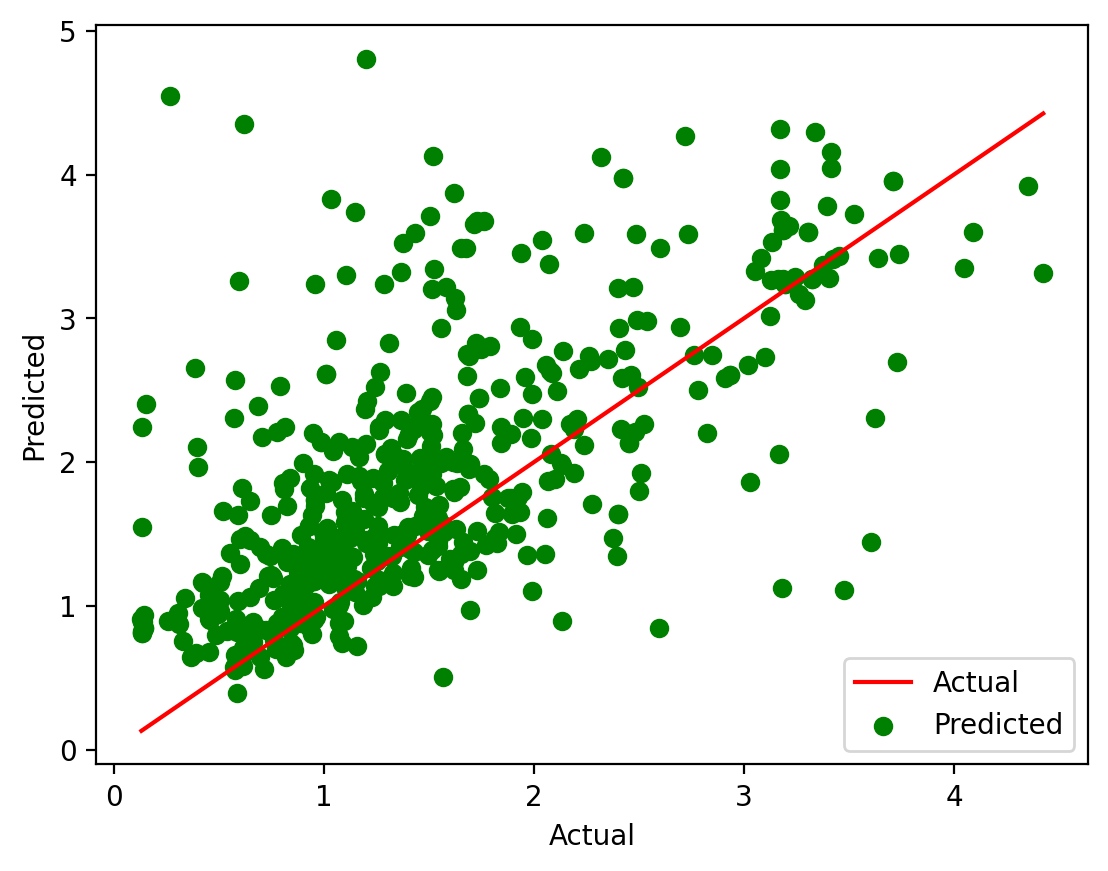

In [105]:
#@title
y_persistent_hat = torch.zeros(X_test_max.shape[0]).to(device)
for i, x in enumerate(y_test_max):
  y_persistent_hat[i] = torch.max(X_test_max[i])
print("RMSE of y (standardized): ", ((y_test_max - y_persistent_hat) ** 2).mean().sqrt().item())
inverted_y, inverted_yhat = inverse_scaler(y_test_max.tolist(), y_persistent_hat.reshape(-1,1).tolist())
print("RMSE of y : ", math.sqrt(mean_squared_error(inverted_y,inverted_yhat)))
print("Correlation between actual and Predicted (mean): ", calculate_corr(y_persistent_hat,y_test_max))
# print("Correlation between actual and Predicted (mean): ", calculate_corr(np.array(inverted_y), np.array(inverted_yhat)))
plot_scatter(inverted_y, inverted_yhat, model_name="Persistence")

y_max, y_min: (tensor(11.8899, device='cuda:0'), tensor(-0.6574, device='cuda:0'))
Epoch 0  | Loss: | Training: 1.6262
Epoch 0  | training loss: 1.626193881034851 | validation loss: 1.3155725002288818 | test loss: 1.2012287378311157
Epoch 1  | Loss: | Training: 1.3469
Epoch 1  | training loss: 1.3468787670135498 | validation loss: 1.1399818658828735 | test loss: 1.0729538202285767
Epoch 2  | Loss: | Training: 1.292
Epoch 2  | training loss: 1.2919585704803467 | validation loss: 1.1065298318862915 | test loss: 1.0570199489593506
Epoch 3  | Loss: | Training: 1.2586
Epoch 3  | training loss: 1.2586110830307007 | validation loss: 1.089266300201416 | test loss: 1.055245280265808
Epoch 4  | Loss: | Training: 1.2276
Epoch 4  | training loss: 1.2276030778884888 | validation loss: 1.0881567001342773 | test loss: 1.06290864944458
Epoch 5  | Loss: | Training: 1.1852
Epoch 5  | training loss: 1.18523108959198 | validation loss: 1.0976263284683228 | test loss: 1.070298433303833
Epoch 6  | Loss: | T

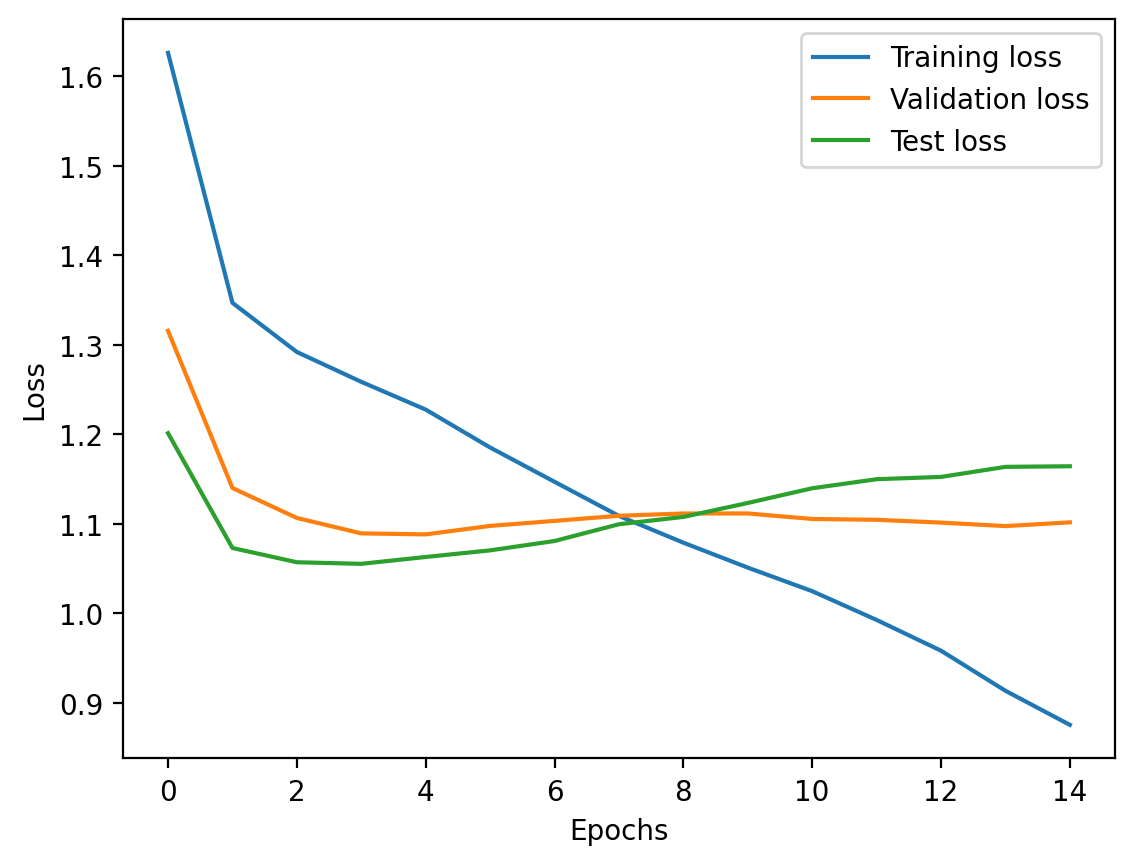

In [109]:
#@title
count_constraint_violation = []
batch_size = 64
lr = 0.001
n_hidden = 15
n_layers = 3
num_epochs = 15
boundary_tolerance = 0.1
train_history = [0] * num_epochs
validation_history = [0] * num_epochs
test_history = [0] * num_epochs

model_fcn_all, mu_hat_all, sigma_hat_all, xi_hat_all, y_all, yhat_all, y_q1_all, y_q2_all = train_model_gev(lambda_ = 0.0, lambda_2=0.5, model_name = "FCN", tuning=False, validation=True, X_train = X_train_max, y_train = y_train_max)
plot_losses(train_history, validation_history, test_history)
# calculate_nll(y_test_max, mu_hat_all, sigma_hat_all, xi_hat_all, name = "LSTM")
# calculate_nll(yhat_all, mu, sigma, xi_all, name = "Ground Truth")

RMSE of y (standardized):  1.580432653427124
RMSE of y :  0.6755165811619565
Correlation between actual and Predicted (mean):  0.6556370602955535


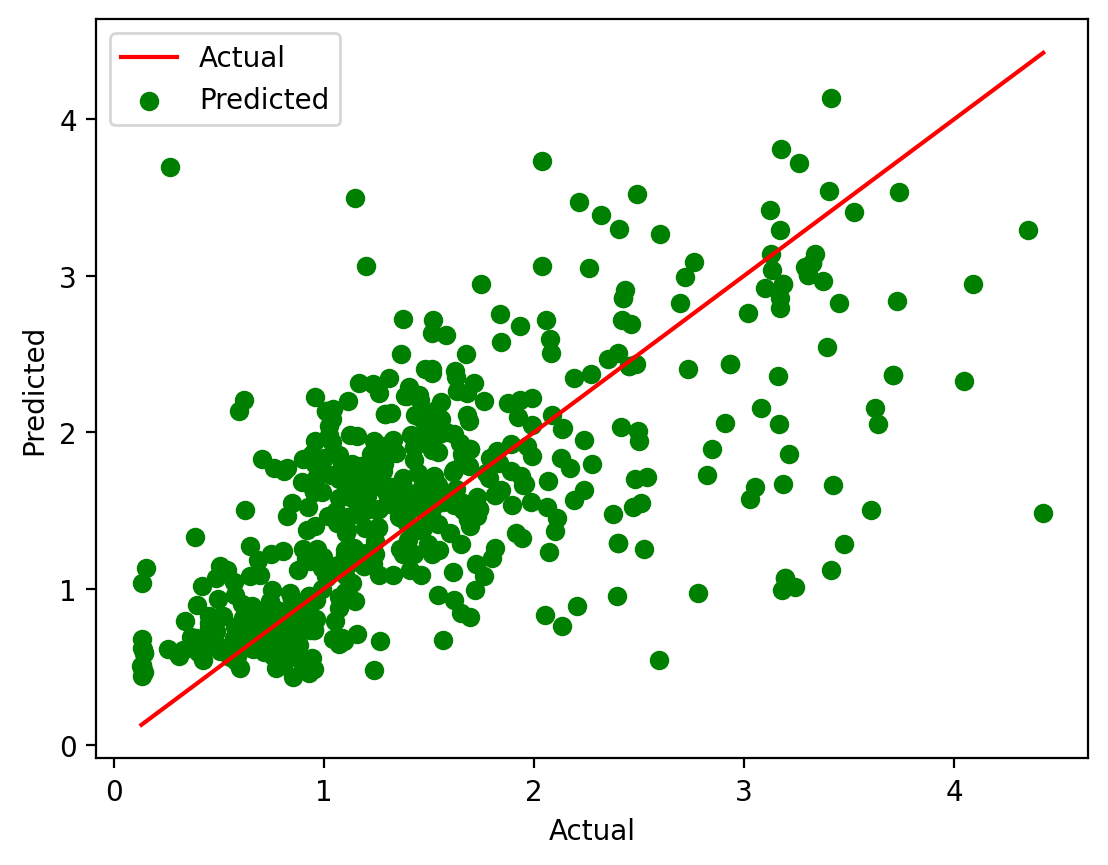

In [110]:
#@title
print("RMSE of y (standardized): ", ((y_all - yhat_all) ** 2).mean().sqrt().item())
inverted_y, inverted_yhat = inverse_scaler(y_all.tolist(), yhat_all.reshape(-1,1).tolist())
print("RMSE of y : ", math.sqrt(mean_squared_error(inverted_y,inverted_yhat)))
print("Correlation between actual and Predicted (mean): ", calculate_corr(y_all, yhat_all))
plot_scatter(inverted_y, inverted_yhat, model_name="Model FCN: y estimations")

y_max, y_min: (tensor(11.8899, device='cuda:0'), tensor(-0.6574, device='cuda:0'))
Epoch 0  | Loss: | Training: 1.8007
Epoch 0  | training loss: 1.8007019758224487 | validation loss: 1.7419085502624512 | test loss: 2.0287528038024902
Epoch 1  | Loss: | Training: 1.4997
Epoch 1  | training loss: 1.4996895790100098 | validation loss: 1.358614444732666 | test loss: 1.4861831665039062
Epoch 2  | Loss: | Training: 1.4686
Epoch 2  | training loss: 1.4686369895935059 | validation loss: 1.3191548585891724 | test loss: 1.4536197185516357
Epoch 3  | Loss: | Training: 1.4766
Epoch 3  | training loss: 1.4766327142715454 | validation loss: 1.3140466213226318 | test loss: 1.4123713970184326
Epoch 4  | Loss: | Training: 1.4334
Epoch 4  | training loss: 1.4333817958831787 | validation loss: 1.3784208297729492 | test loss: 1.4039959907531738
Epoch 5  | Loss: | Training: 1.3819
Epoch 5  | training loss: 1.381871223449707 | validation loss: 1.2331396341323853 | test loss: 1.3252649307250977
Epoch 6  | Lo

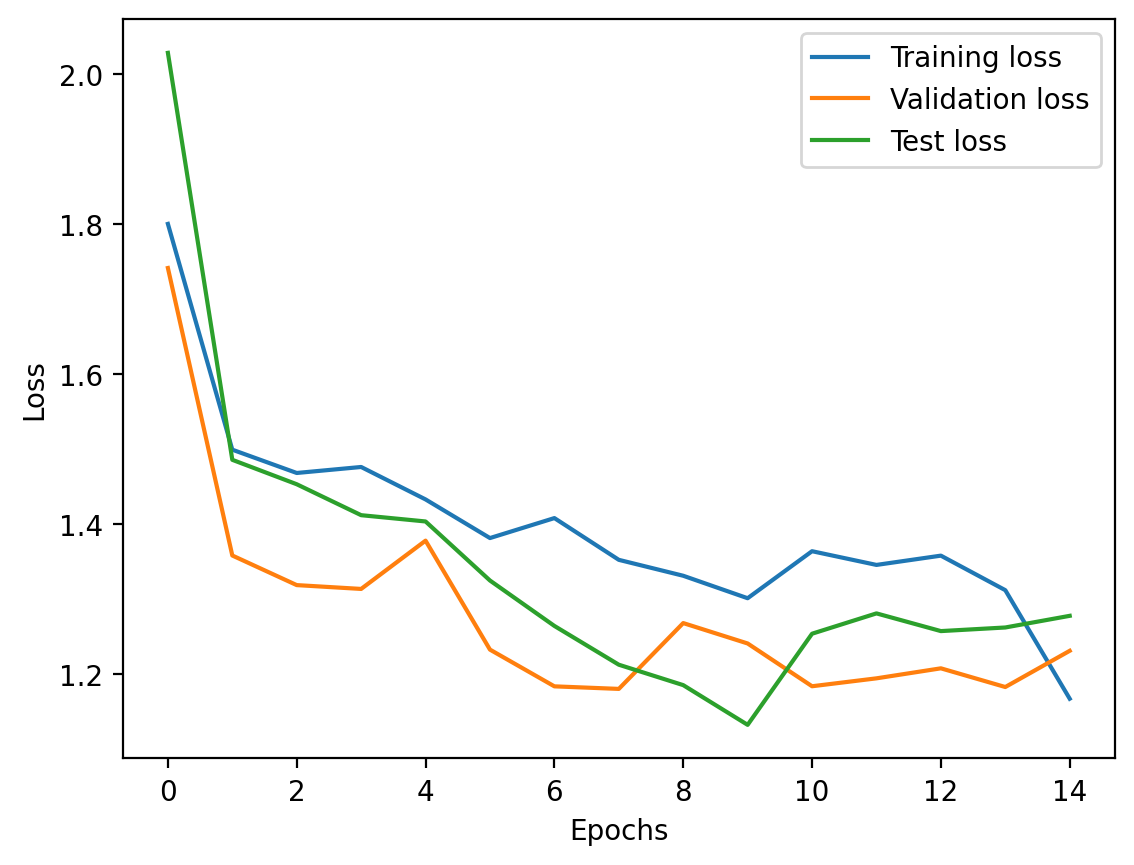

In [111]:
#@title
count_constraint_violation = []
batch_size = 64
lr = 0.001
n_hidden = 15
n_layers = 3
num_epochs = 15
boundary_tolerance = 0.1
train_history = [0] * num_epochs
validation_history = [0] * num_epochs
test_history = [0] * num_epochs

model_fcn_all, mu_hat_all, sigma_hat_all, xi_hat_all, y_all, yhat_all, y_q1_all, y_q2_all = train_model_gev(lambda_ = 0.0, lambda_2=0.5, model_name = "LSTM_GEV", tuning=False, validation=True, X_train = X_train_max, y_train = y_train_max)
plot_losses(train_history, validation_history, test_history)
# calculate_nll(y_test_max, mu_hat_all, sigma_hat_all, xi_hat_all, name = "LSTM")
# calculate_nll(yhat_all, mu, sigma, xi_all, name = "Ground Truth")

RMSE of y (standardized):  1.5250009298324585
RMSE of y :  0.6518236913645993
Correlation between actual and Predicted (mean):  0.6456481130690364


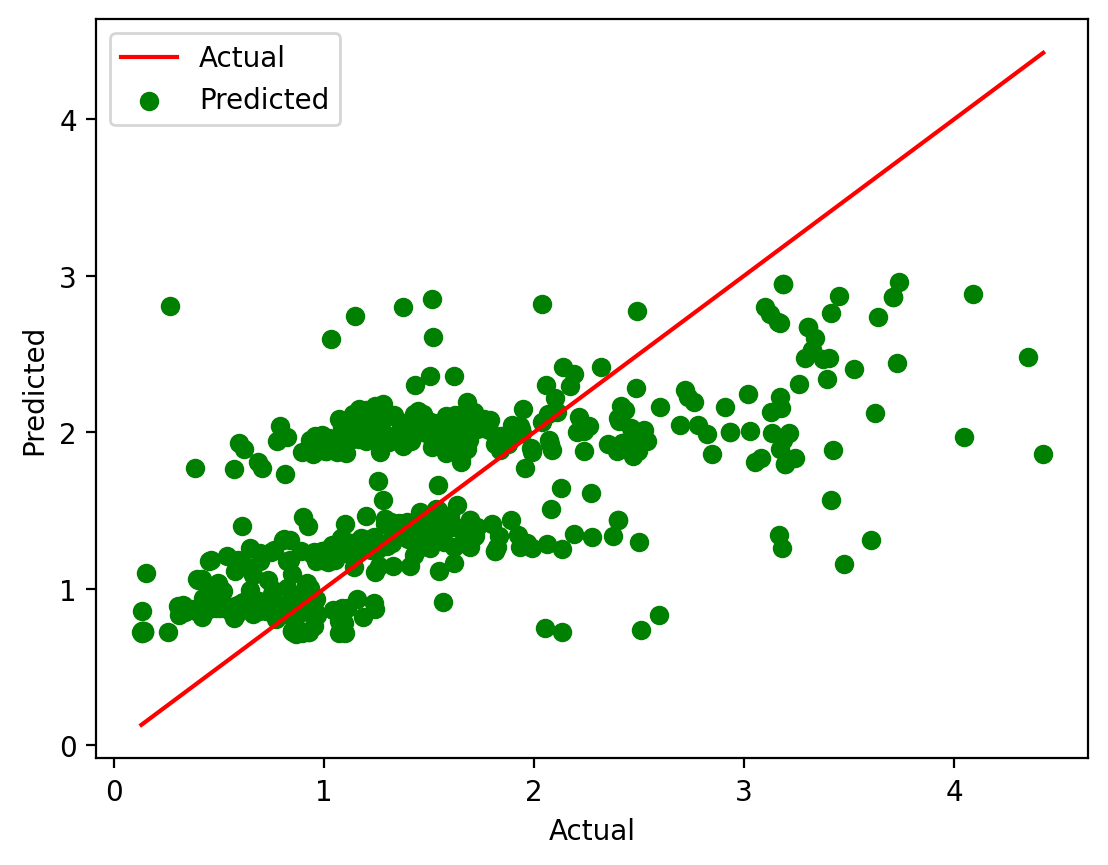

In [112]:
#@title
print("RMSE of y (standardized): ", ((y_all - yhat_all) ** 2).mean().sqrt().item())
inverted_y, inverted_yhat = inverse_scaler(y_all.tolist(), yhat_all.reshape(-1,1).tolist())
print("RMSE of y : ", math.sqrt(mean_squared_error(inverted_y,inverted_yhat)))
print("Correlation between actual and Predicted (mean): ", calculate_corr(y_all, yhat_all))
plot_scatter(inverted_y, inverted_yhat, model_name="Model LSTM: y estimations")

y_max, y_min: (tensor(11.8899, device='cuda:0'), tensor(-0.6574, device='cuda:0'))
Epoch 0  | Loss: | Training: 1.7932
Epoch 0  | training loss: 1.793185830116272 | validation loss: 2.0443685054779053 | test loss: 2.0831758975982666
Epoch 1  | Loss: | Training: 1.7684
Epoch 1  | training loss: 1.7683706283569336 | validation loss: 1.9966148138046265 | test loss: 2.0342438220977783
Epoch 2  | Loss: | Training: 1.7654
Epoch 2  | training loss: 1.765362024307251 | validation loss: 1.9908357858657837 | test loss: 2.028249979019165
Epoch 3  | Loss: | Training: 1.771
Epoch 3  | training loss: 1.770973801612854 | validation loss: 1.9981039762496948 | test loss: 2.035637855529785
Epoch 4  | Loss: | Training: 1.7719
Epoch 4  | training loss: 1.7718713283538818 | validation loss: 2.0002663135528564 | test loss: 2.0376534461975098
Epoch 5  | Loss: | Training: 1.7747
Epoch 5  | training loss: 1.7746931314468384 | validation loss: 1.9992139339447021 | test loss: 2.0358335971832275
Epoch 6  | Loss: 

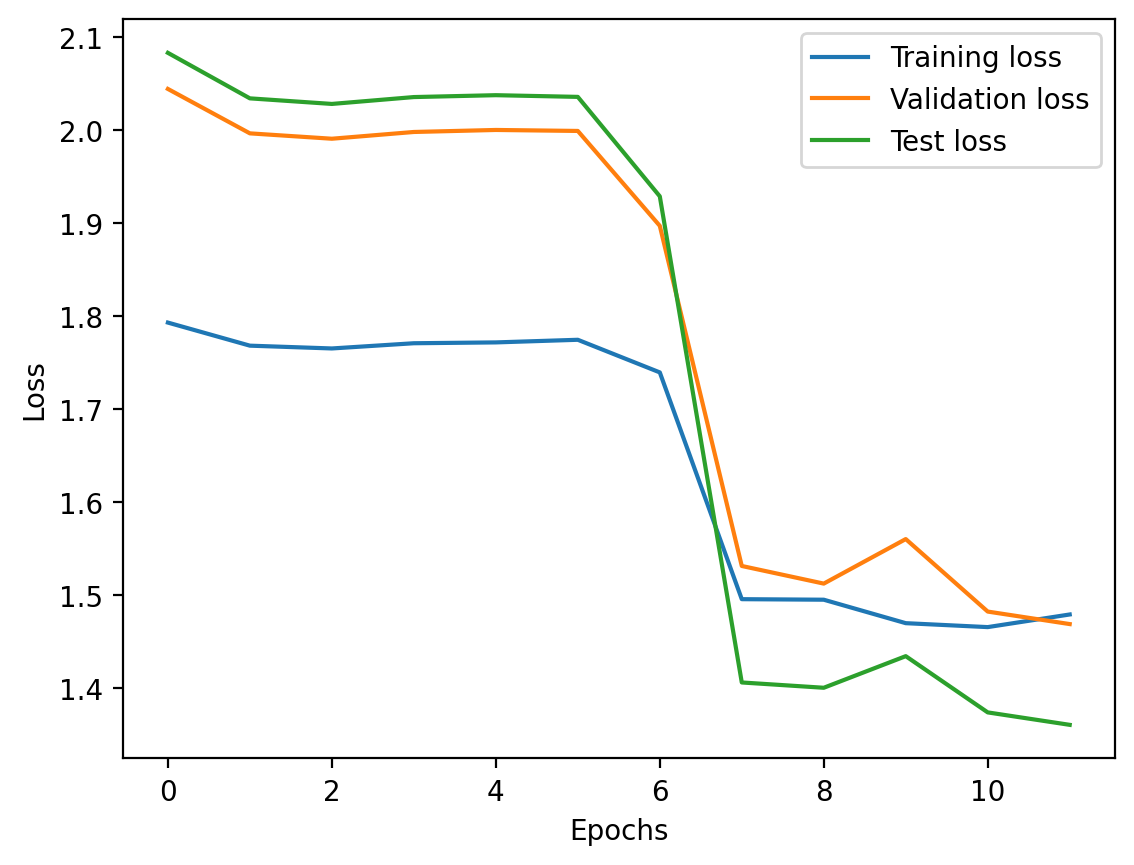

In [144]:
#@title
count_constraint_violation = []
batch_size = 128
lr = 0.001
num_epochs = 12
boundary_tolerance = 0.1
train_history = [0] * num_epochs
validation_history = [0] * num_epochs
test_history = [0] * num_epochs

model_fcn_all, mu_hat_all, sigma_hat_all, xi_hat_all, y_all, yhat_all, y_q1_all, y_q2_all = train_model_gev(lambda_ = 0.0, lambda_2=0.5, model_name = "Trans", tuning=False, validation=True, X_train = X_train_max, y_train = y_train_max)
plot_losses(train_history, validation_history, test_history)
# calculate_nll(y_test_max, mu_hat_all, sigma_hat_all, xi_hat_all, name = "LSTM")
# calculate_nll(yhat_all, mu, sigma, xi_all, name = "Ground Truth")

RMSE of y (standardized):  1.885144829750061
RMSE of y :  0.8057582228392792
Correlation between actual and Predicted (mean):  0.4020860823583794


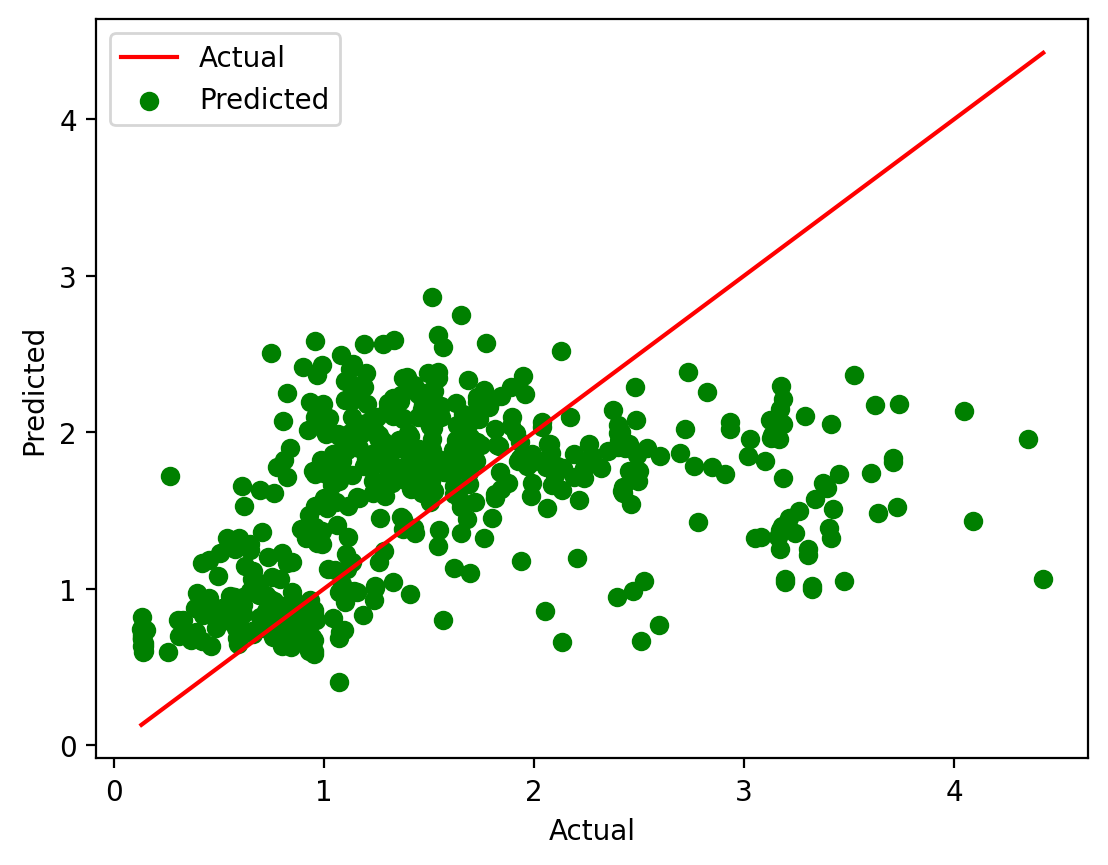

In [145]:
#@title
print("RMSE of y (standardized): ", ((y_all - yhat_all) ** 2).mean().sqrt().item())
inverted_y, inverted_yhat = inverse_scaler(y_all.tolist(), yhat_all.reshape(-1,1).tolist())
print("RMSE of y : ", math.sqrt(mean_squared_error(inverted_y,inverted_yhat)))
print("Correlation between actual and Predicted (mean): ", calculate_corr(y_all, yhat_all))
plot_scatter(inverted_y, inverted_yhat, model_name="Model Transformer: y estimations")

y_max, y_min: (tensor(11.8899, device='cuda:0'), tensor(-0.6574, device='cuda:0'))
initial values: mu (mean): 1.4537065029144287, sigma (mean): 1.3329782485961914, xi_p (mean): 0.1037418320775032, xi_n (mean): 0.8910713791847229
initial values after fixing:  mu (mean): 1.4537065029144287, sigma (mean): 1.3329782485961914, xi_p (mean): 0.1431809812784195, xi_n (mean): 0.043181002140045166
Epoch 0  | Loss: | Training: 2.2062 | EVT(NLL+RMSE(xi)): 1.7586 | RMSE(y): 2.256 | GEV(NLL): 1.9434 | RMSE(xi_p_n): 0.0954| mu  sigma  xi_p xi_n: (1.8015, 1.6287, 0.1312, 0.0359)
Epoch 0  | training loss: 2.206230878829956 | validation loss: 2.1396586894989014 | test loss: 2.1448512077331543
Epoch 1  | Loss: | Training: 1.7584 | EVT(NLL+RMSE(xi)): 1.9935 | RMSE(y): 1.7323 | GEV(NLL): 2.1673 | RMSE(xi_p_n): 0.4297| mu  sigma  xi_p xi_n: (2.5263, 2.3162, 0.3053, -0.1243)
Epoch 1  | training loss: 1.7584404945373535 | validation loss: 1.873228669166565 | test loss: 1.9062060117721558
Epoch 2  | Loss: | Tr

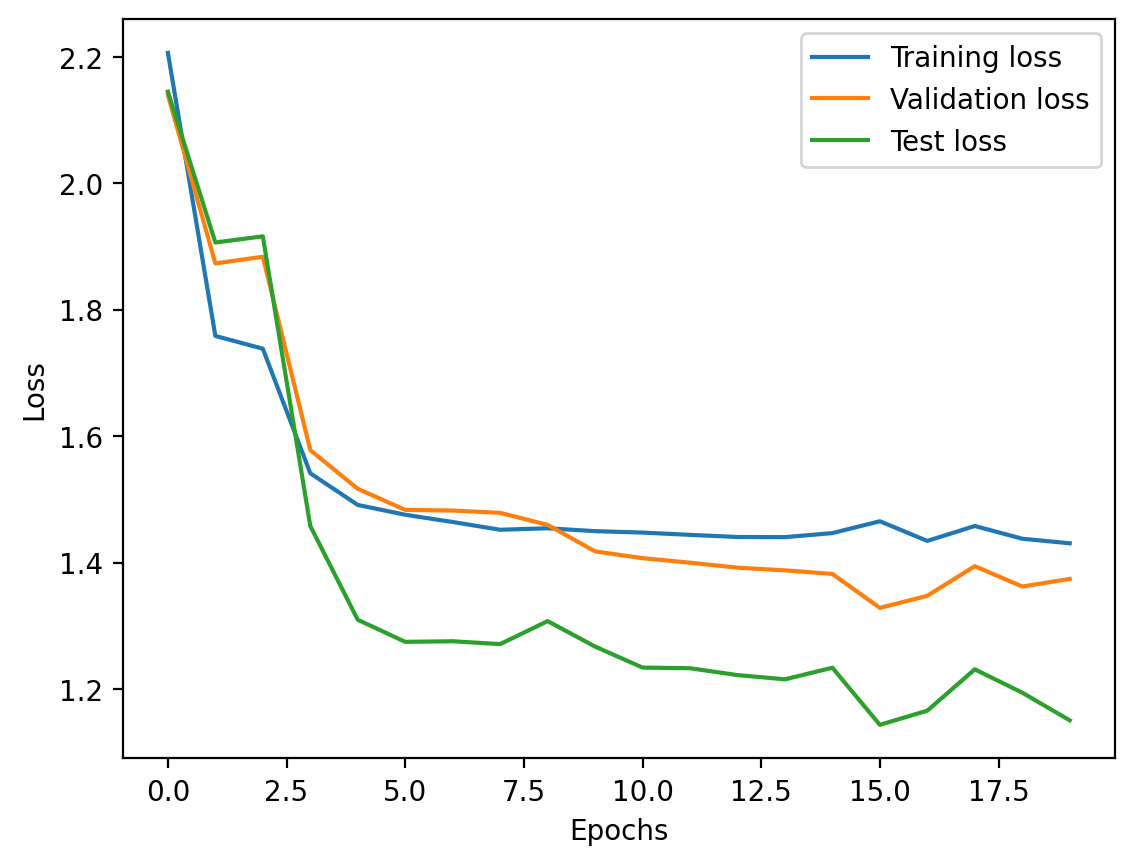

In [122]:
count_constraint_violation = []
batch_size = 128
lr = 0.001
n_hidden = 10
n_layers = 3
num_epochs = 20
boundary_tolerance = 0.1
train_history = [0] * num_epochs
validation_history = [0] * num_epochs
test_history = [0] * num_epochs

model_fcn_all, mu_hat_all, sigma_hat_all, xi_hat_all, y_all, yhat_all, y_q1_all, y_q2_all = train_model_gev(lambda_ = 0.1, lambda_2=0.9, model_name = "M3_GEV", tuning=False, validation=True, X_train = X_train_max, y_train = y_train_max)
plot_losses(train_history, validation_history, test_history)
calculate_nll(y_test_max, mu_hat_all, sigma_hat_all, xi_hat_all, name = "Model M3 Estimation (y)")
# calculate_nll(yhat_all, mu, sigma, xi_all)

PICP:  0.95703125
Correlation between actual and Predicted (mean):  0.6680978260624603
RMSE of y (standardized):  1.4801665544509888
RMSE of y :  0.6326603578935602


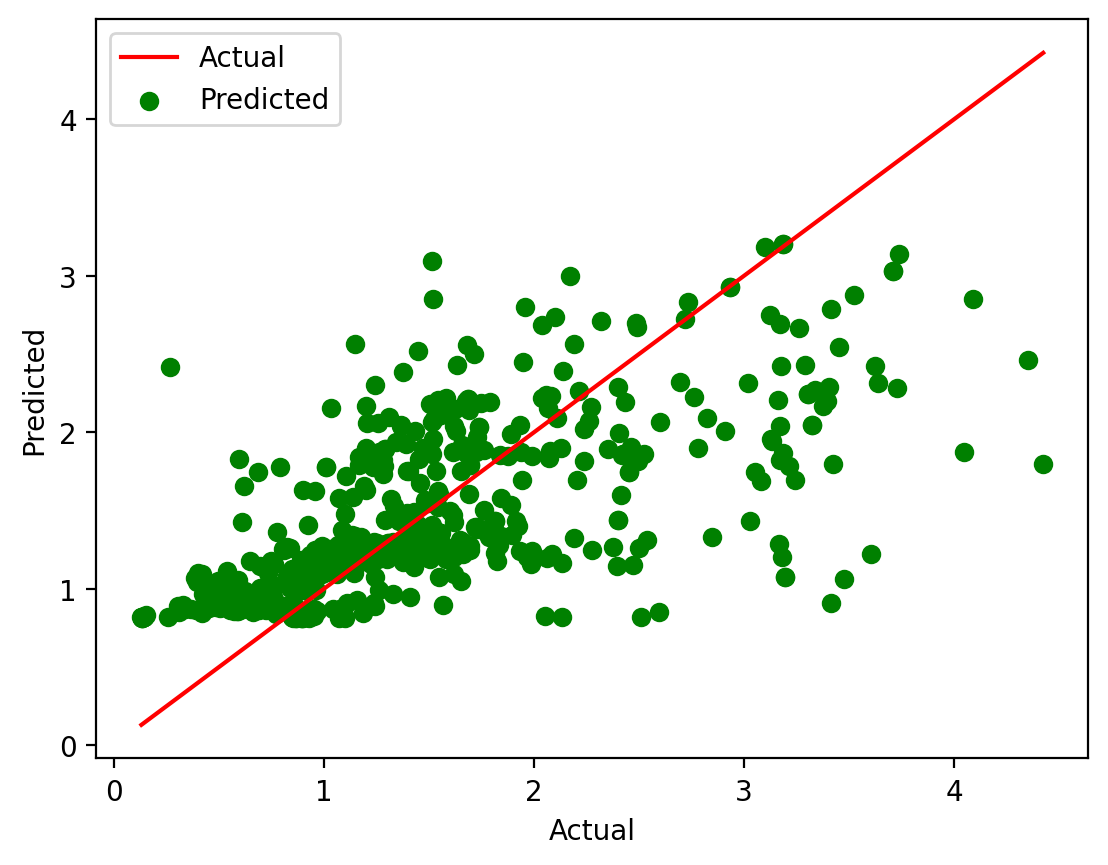

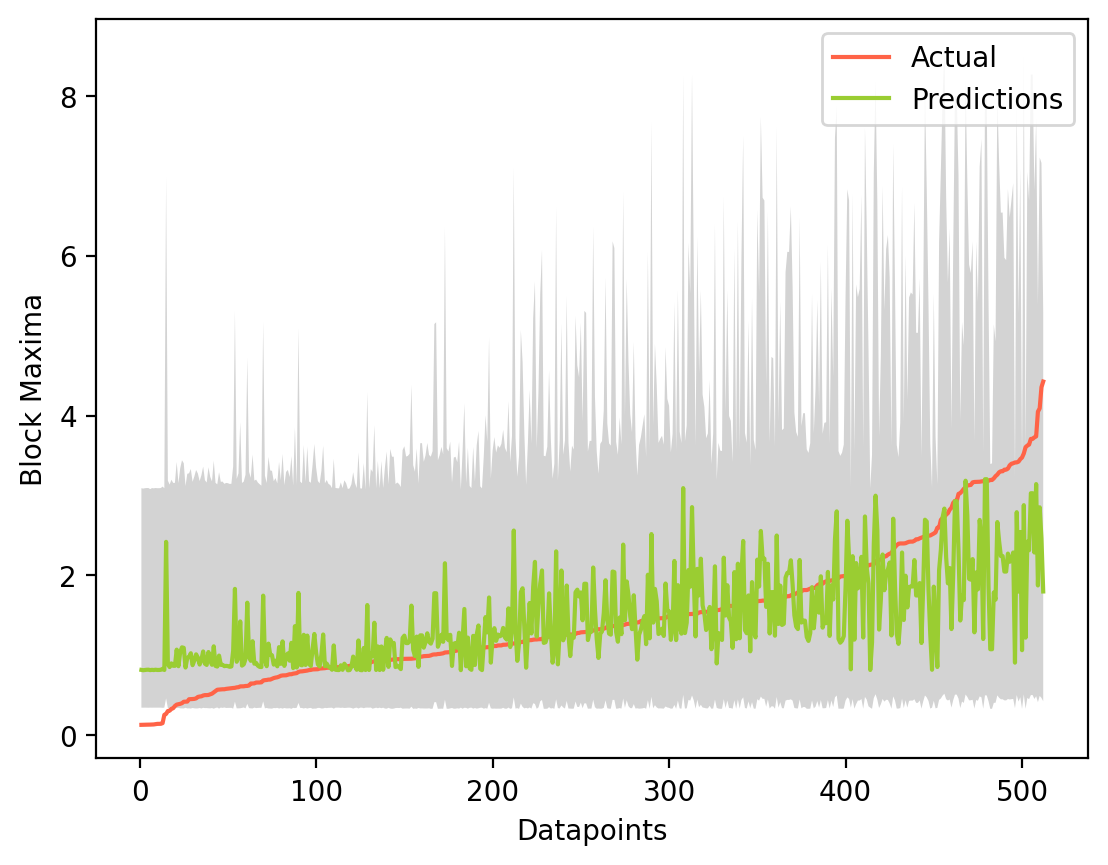

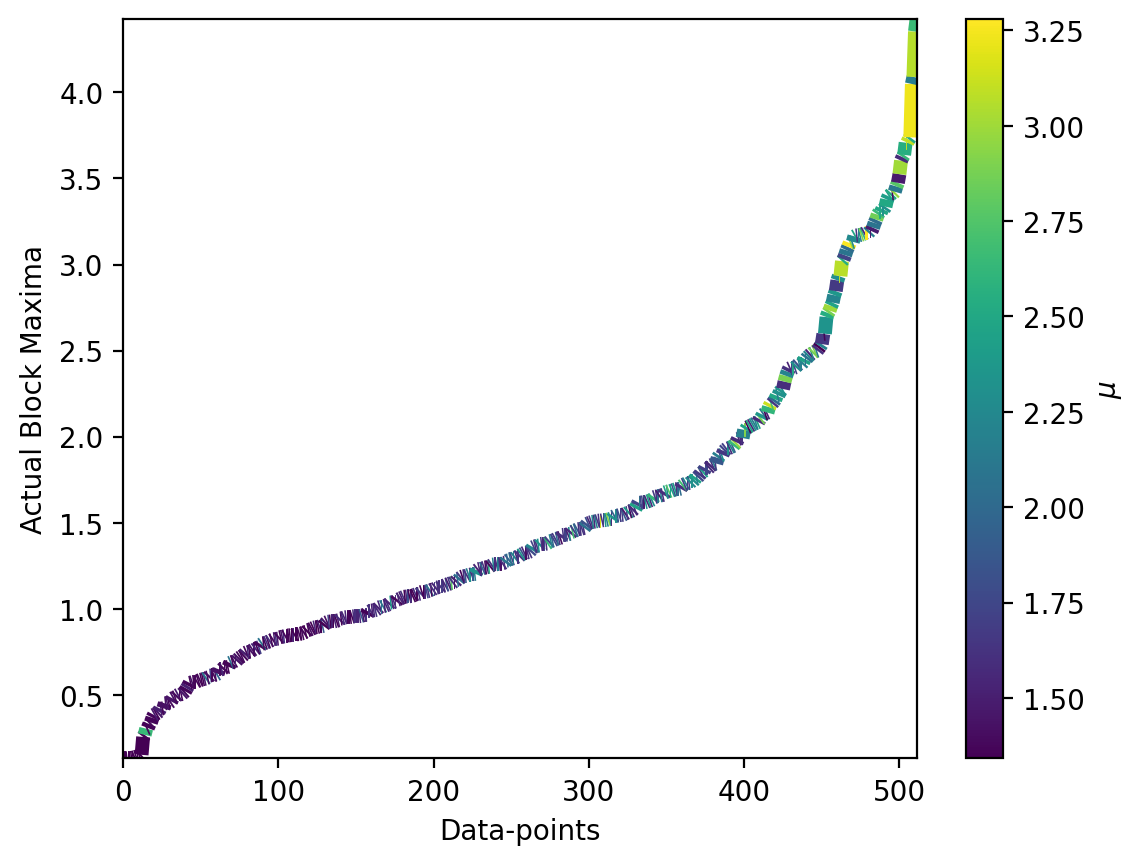

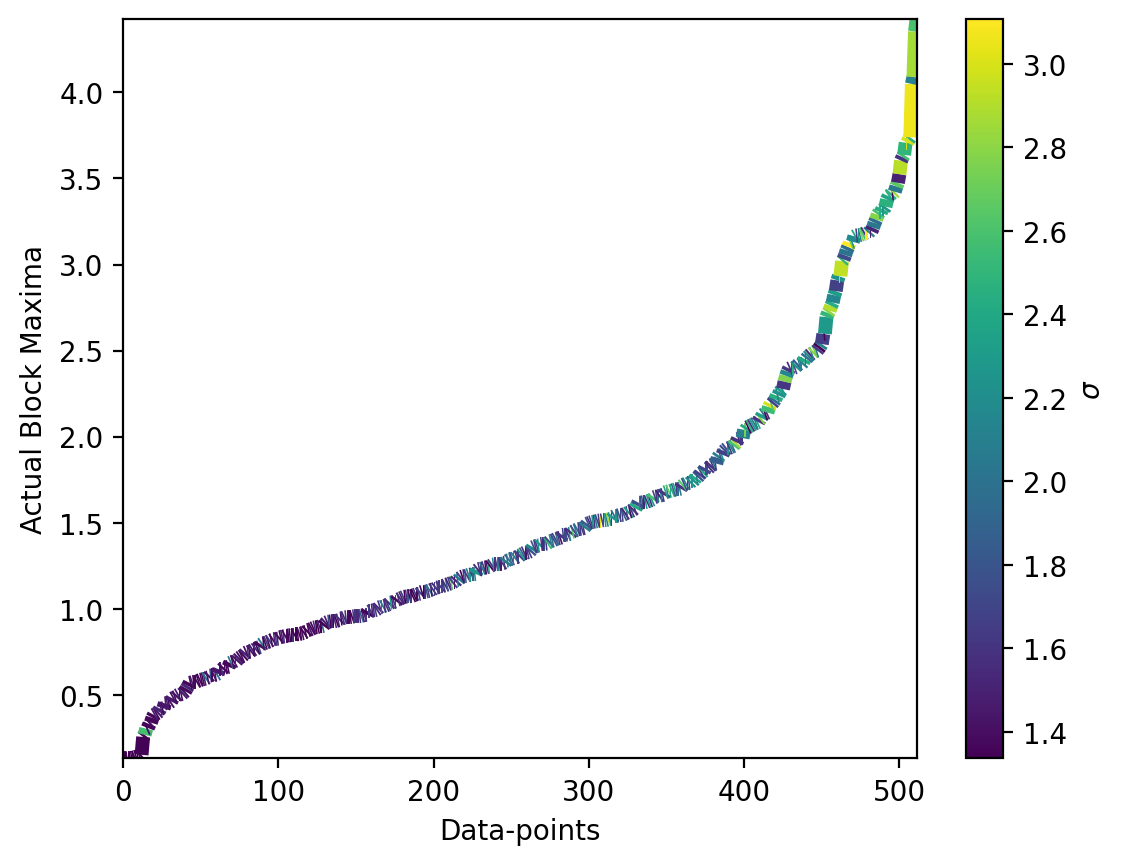

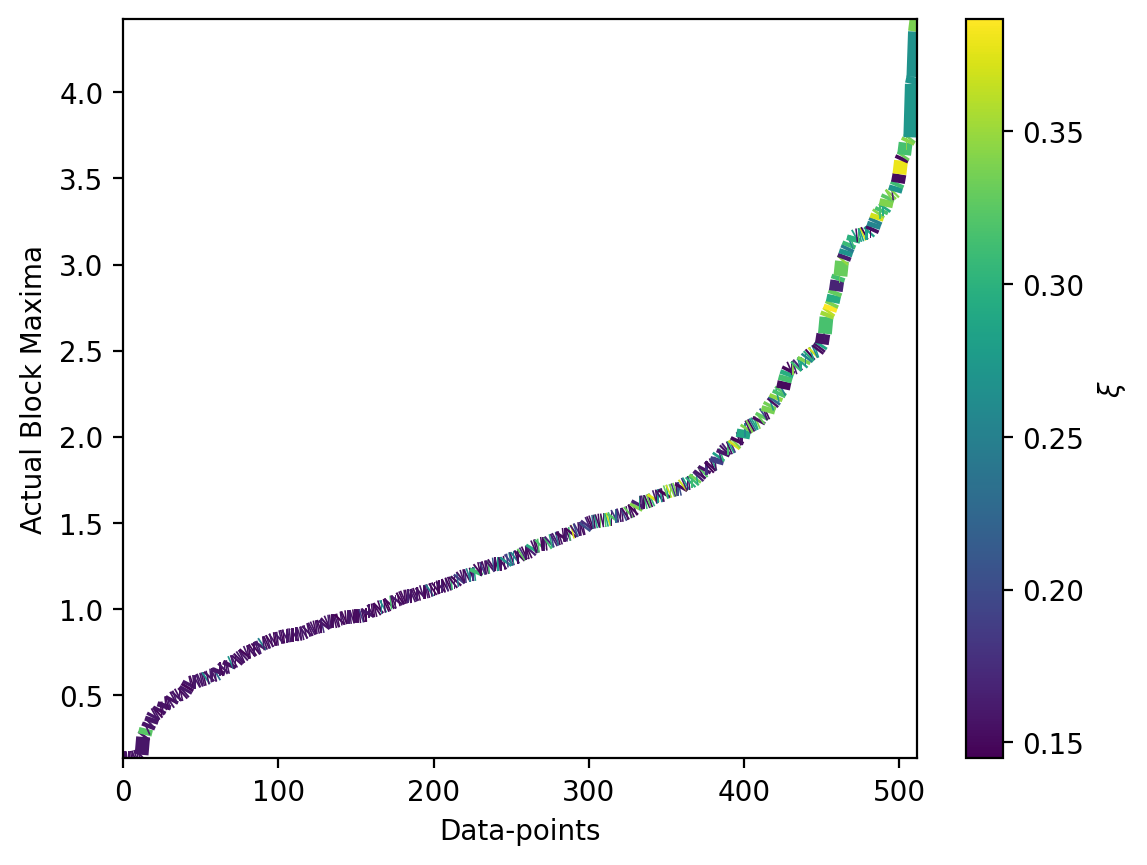

In [123]:
all_result(y_all.cpu(), yhat_all.cpu(), y_q1_all.cpu(), y_q2_all.cpu(), mu_hat_all.cpu(), sigma_hat_all.cpu(), xi_hat_all.cpu(), model_name="M3_l1=0.5_l2=0.9,hidden=10,layer=2, epochs=30")